In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import scipy.stats as stats
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
pd.set_option('display.max_columns', 300)

import warnings
warnings.filterwarnings('ignore')

# Who is the non-voter?
Public opinion polling faces many challenges related to sampling methodologies, but these obstacles are compounded when the polling attempts to predict voter behavior in a national election. In particular, even if a truly sufficiently large random sample of the population was interviewed, the pollster has limited means of determining which respondents will actually vote in the upcoming election.

Shortcomings in likely voter prediction can lead to inaccurate projections, most recently evident in the 2016 presidential election. In order to build better models for the future, it is worthwhile to backtrack to the basics and ask a fundamental question: "Who is the non-voter?"

### The Data

Fortunately, the American National Election Studies (ANES) Cumulative Time Series Study has been conducting pre and post-election surveys since 1948, though for the purpose of analysis only respondents from 2000 and later are considered. The availability of post-election data means that we can examine *whether* repondents actually voted rather than mere *intent* to vote like most traditional public opinion polls.

### A Note About Sampling Weights
The ANES studies use stratified sampling, but for the purposes of binary classification, sampling weights are ignored. This means that the statements below serve to describe the sample data rather than make inferences to the general population, unless otherwise stated.

In [47]:
df = pd.read_csv('../data/anes_cdf_converted.csv')
df.head()

,Unnamed: 0,year,age,congressional_district,state,gender,weight,VCF0108,VCF0113,VCF0127,VCF0143,VCF0146,VCF0311,VCF0346,VCF0347,VCF0348,VCF0349,VCF0358,VCF0359,VCF0360,VCF0361,VCF0370,VCF0371,VCF0372,VCF0373,VCF0374,VCF0380,VCF0386,VCF0392,VCF0475,VCF0481,VCF0487,VCF0493,VCF0450,VCF0501,VCF0702,VCF0704a,VCF0707,VCF0708,VCF0717,VCF0718,VCF0719,VCF0720,VCF0721,VCF0724,VCF0729,VCF0731,VCF0740,VCF0741,VCF0742,VCF0846,VCF0878,VCF0905,VCF9021,VCF9029,VCF9030a,VCF9030b,VCF9030c,VCF9031,VCF0204_dk,VCF0204,VCF0206_dk,VCF0206,VCF0207_dk,VCF0207,VCF0209_dk,VCF0209,VCF0210_dk,VCF0210,VCF0211_dk,VCF0211,VCF0212_dk,VCF0212,VCF0213_dk,VCF0213,VCF0217_dk,VCF0217,VCF0218_dk,VCF0218,VCF0219_dk,VCF0219,VCF0220_dk,VCF0220,VCF0223_dk,VCF0223,VCF0224_dk,VCF0224,VCF0227_dk,VCF0227,VCF0228_dk,VCF0228,VCF0231_dk,VCF0231,VCF0232_dk,VCF0232,VCF0233_dk,VCF0233,VCF0234_dk,VCF0234,VCF0253_dk,VCF0253,VCF0290,VCF0291,VCF0412,VCF0413,VCF0414,VCF0415,VCF0424_dk,VCF0424,VCF0425_dk,VCF0425,VCF0426_dk,VCF0426,VCF0427_dk,VCF0427,VCF0428_dk,VCF0428,VCF0429_dk,VCF0429,VCF0471_dk,VCF0471,VCF0906_dk,VCF0906,VCF0907_dk,VCF0907,VCF0908_dk,VCF0908,VCF0909_dk,VCF0909,VCF9005_dk,VCF9005,VCF9056_dk,VCF9056,VCF9057_dk,VCF9057,VCF0648,VCF0649,VCF0656,VCF0801_dk,VCF0801,VCF0138,VCF0723,VCF0733,VCF1015,VCF1016,VCF0114_r1,VCF0114_r2,VCF0503_dk,VCF0503,VCF0504_dk,...,VCF0606_dk,VCF0606,VCF0624_dk,VCF0624,VCF0703,VCF0838_dk,VCF0838,VCF0847,VCF0850_dk,VCF0850,VCF0867a_dk,VCF0867a,VCF0870_dk,VCF0870,VCF0871_dk,VCF0871,VCF0872_dk,VCF0872,VCF0879_dk,VCF0879,VCF0880a,VCF0881_dk,VCF0881,VCF9009_dk,VCF9009,VCF9032,VCF9045_dk,VCF9045,VCF0105a_oh0,VCF0105a_oh1,VCF0105a_oh2,VCF0105a_oh3,VCF0105a_oh4,VCF0105a_oh5,VCF0105a_oh6,VCF0107_oh0,VCF0107_oh1,VCF0107_oh2,VCF0107_oh3,VCF0107_oh4,VCF0107_oh5,VCF0107_oh6,VCF0112_oh0,VCF0112_oh1,VCF0112_oh2,VCF0112_oh3,VCF0116_oh0,VCF0116_oh1,VCF0116_oh2,VCF0116_oh3,VCF0116_oh4,VCF0116_oh5,VCF0116_oh6,VCF0116_oh7,VCF0128_oh0,VCF0128_oh1,VCF0128_oh2,VCF0128_oh3,VCF0128_oh4,VCF0147_oh0,VCF0147_oh1,VCF0147_oh2,VCF0147_oh3,VCF0147_oh4,VCF0147_oh5,VCF0147_oh6,VCF0149_oh0,VCF0149_oh1,VCF0149_oh2,VCF0149_oh3,VCF0149_oh4,VCF0302_oh0,VCF0302_oh1,VCF0302_oh2,VCF0302_oh3,VCF0302_oh4,VCF0302_oh5,VCF0704_oh0,VCF0704_oh1,VCF0704_oh2,VCF0704_oh3,VCF0709_oh0,VCF0709_oh1,VCF0709_oh2,VCF0709_oh3,VCF0709_oh4,VCF0710_oh0,VCF0710_oh1,VCF0710_oh2,VCF0710_oh3,VCF0710_oh4,VCF0713_oh0,VCF0713_oh1,VCF0713_oh2,VCF0713_oh3,VCF0713_oh4,VCF0713_oh5,VCF0714_oh0,VCF0714_oh1,VCF0714_oh2,VCF0734_oh0,VCF0734_oh1,VCF0734_oh2,VCF0734_oh3,VCF0734_oh4,VCF0734_oh5,VCF0734_oh6,VCF0734_oh7,VCF0734_oh8,VCF0734_oh9,VCF0736_oh0,VCF0736_oh1,VCF0736_oh2,VCF0736_oh3,VCF0804_oh0,VCF0804_oh1,VCF0804_oh2,VCF0804_oh3,VCF0804_oh4,VCF0823_oh0,VCF0823_oh1,VCF0823_oh2,VCF0823_oh3,VCF0904_oh0,VCF0904_oh1,VCF0904_oh2,VCF0904_oh3,VCF1004_oh0,VCF1004_oh1,VCF1004_oh2,VCF1004_oh3,VCF1004_oh4,VCF9030_oh0,VCF9030_oh1,VCF9030_oh2,VCF9030_oh3,VCF9030_oh4,VCF9030_oh5,VCF9131_oh0,VCF9131_oh1,VCF9131_oh2,VCF9131_oh3,VCF9132_oh0,VCF9132_oh1,VCF9132_oh2,VCF9132_oh3,VCF9133_oh0,VCF9133_oh1,VCF9133_oh2,VCF9133_oh3
0,0,2000,49.0,MN01,MN,0,1.2886,0.0,0,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN,1.0,0.0,1.0,0.0,False,75.0,False,75.0,False,75.0,False,70.0,False,65.0,False,50.0,False,70.0,False,90.0,False,65.0,False,55.0,False,NaN,False,70.0,False,75.0,False,75.0,False,70.0,False,60.0,False,70.0,False,30.0,False,NaN,False,85.0,False,65.0,65.0,40.0,60.0,50.0,95.0,NaN,False,65.0,True,NaN,False,60.0,True,NaN,False,-0.0,False,65.0,False,40.0,False,65.0,False,85.0,False,85.0,False,65.0,False,65.0,False,40.0,False,90.0,100.0,75.0,55.0,False,55.0,0,2.0,7,43.0,9.0,68.0,95.0,False,2.0,False,...,False,2.0,False,3.0,3.0,False,2.0,3.0,False,2.0,False,4.0,False,1.0,False,1.0,False,1.0,False,NaN,2.0,False,2.0,False,5.0,3.0,False,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1

Collectively, non-voters comprise a little over a fifth of the total sample of respondents from 2000 and later. However, the data has a notable issue in that the majority of responses are from the 2012 election. Thus, it will be important to verify that any inferences made about non-voters generalize to multiple election cycles.

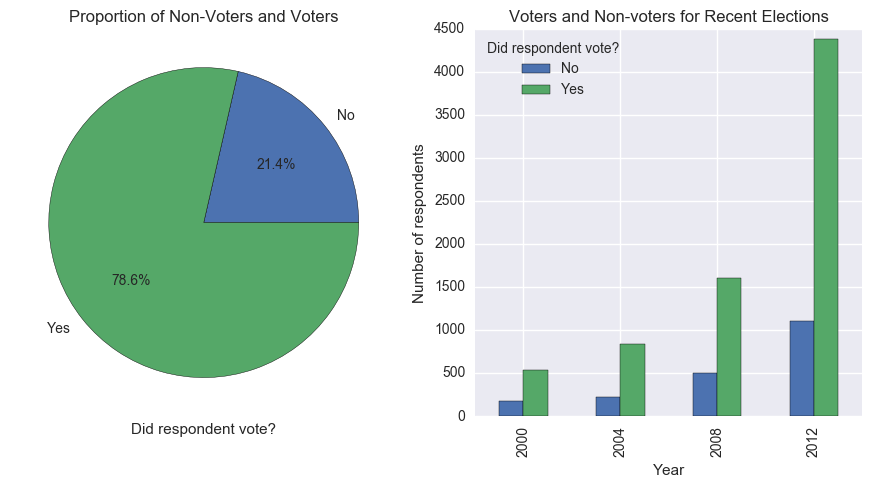

In [3]:
fig, axes = plt.subplots(1, 2, figsize = (11, 5))

g = df.VCF0702.value_counts().sort_index().plot(kind = 'pie', ax = axes[0], labels = ['No','Yes'], autopct='%1.1f%%')
g.set(title = 'Proportion of Non-Voters and Voters', xlabel = 'Did respondent vote?', ylabel = ' ')
plt.legend(labels = ['No','Yes'])

df_temp = df.groupby([df.year, df.VCF0702]).size()
df_temp = df_temp.unstack('VCF0702')
g = df_temp.plot(kind = 'bar', ax = axes[1])
g.set(xlabel = 'Year', ylabel = 'Number of respondents', title = 'Voters and Non-voters for Recent Elections')
g.legend(['No','Yes'], loc = 0, title = 'Did respondent vote?')

# Do young people really not vote? 

From the plot below, we can see that the conventional wisdom holds true, with a substantial number of twenty to twenty-five year olds comprising the non-voting sample. The inverse also appears to hold: with older voters voting most frequently. While the exact distributions change with respect to election year, the general characterization that non-voters are typically much younger than voters remains valid.

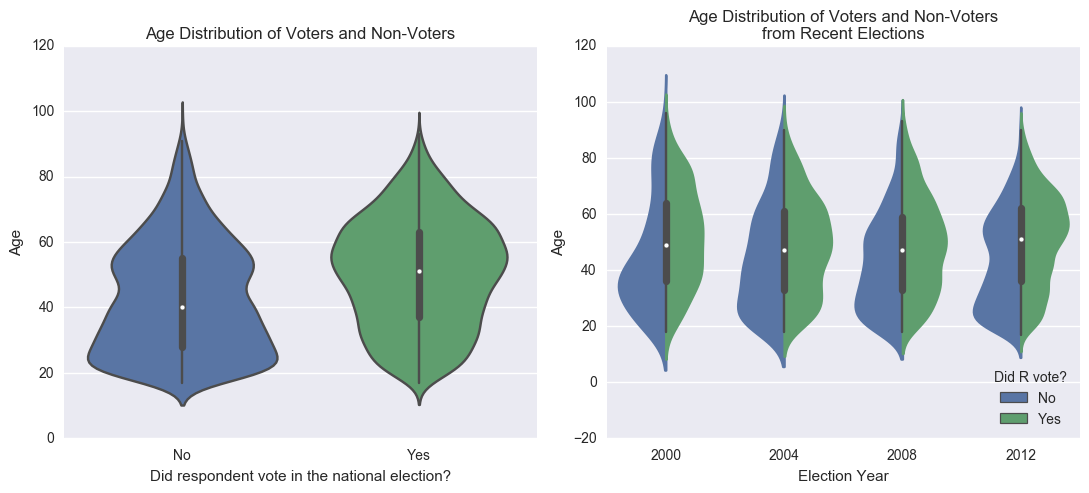

In [4]:
fig, axes = plt.subplots(1, 2, figsize = (11, 5))
df_temp = df[df.age > 10]
g = sns.violinplot(x = df_temp.VCF0702, y = df_temp.age, bw = .2, ax = axes[0])
g.set(title = 'Age Distribution of Voters and Non-Voters', xticklabels = ['No','Yes'])
g.set(xlabel = 'Did respondent vote in the national election?', ylabel = 'Age')
g = sns.violinplot(x = df_temp.year, y = df_temp.age, hue = df_temp.VCF0702, ax = axes[1], split = True)
g.set(title = 'Age Distribution of Voters and Non-Voters\nfrom Recent Elections')
g.set(xlabel = 'Election Year', ylabel = 'Age')
handles, labels = g.get_legend_handles_labels()
g.legend(handles, ['No','Yes'], title = 'Did R vote?', loc = 4)
plt.tight_layout()

# How apathetic are non-voters?
The data confirms that of respondents who did not vote, a much greater proportion did not care who wins the election, no matter the election year.

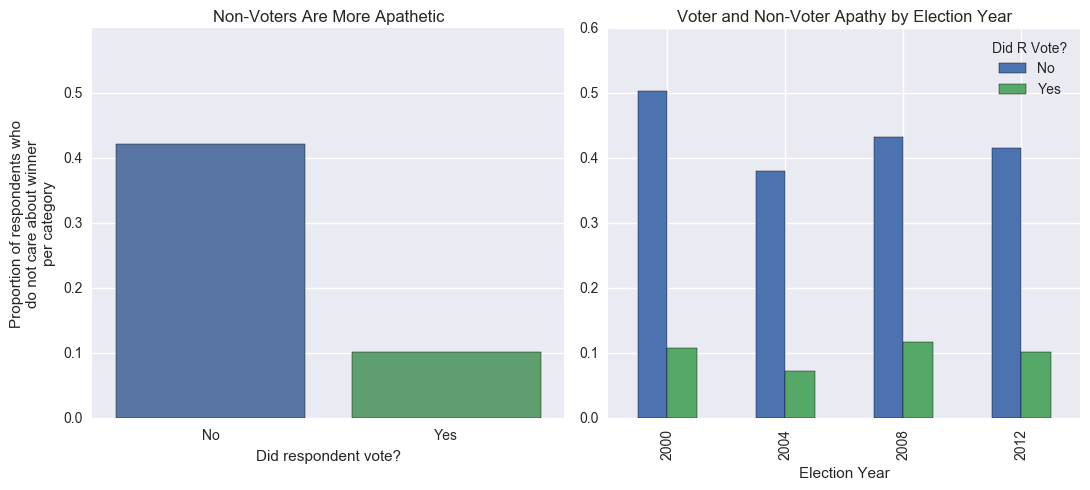

In [5]:
temp_df = df[:]
feature = 'VCF0702'

fig, axes = plt.subplots(1, 2, figsize = (11, 5))

n1 = sum(temp_df[feature] == 0); n2 = sum(temp_df[feature] == 1)
x1 = sum((temp_df[feature] == 0) & (temp_df['VCF0311'] == 0))
x2 = sum((temp_df[feature] == 1) & (temp_df['VCF0311'] == 0))
p1 = x1 / n1; p2 = x2 / n2
g = sns.barplot(['No','Yes'],[p1,p2], ax = axes[0])
g.set(title = 'Non-Voters Are More Apathetic', xlabel = 'Did respondent vote?',
     ylabel = 'Proportion of respondents who\ndo not care about winner\nper category', ylim = (0,0.6))

temp_df = temp_df.groupby(['year','VCF0702','VCF0311']).size()
temp_df = temp_df.unstack('year')
p1 = temp_df.iloc[0,:] / (temp_df.iloc[0,:] + temp_df.iloc[1,:])
p2 = temp_df.iloc[2,:] / (temp_df.iloc[2,:] + temp_df.iloc[3,:])
p = pd.concat([p1, p2], axis = 1)
g = p.plot(kind = 'bar', ax = axes[1])
g.set(title = 'Voter and Non-Voter Apathy by Election Year', xlabel = 'Election Year')
g.legend(title = 'Did R Vote?', labels = ['No','Yes'])

plt.tight_layout()

### Is it the case that young voters are more apathetic?
Not only does the data below show that this is indeed the case, it is striking how much the age distribution of engaged and apathetic respondents mirrors that of voters and non-voters. This suggests that being young and apathetic about the political process may be closely related.

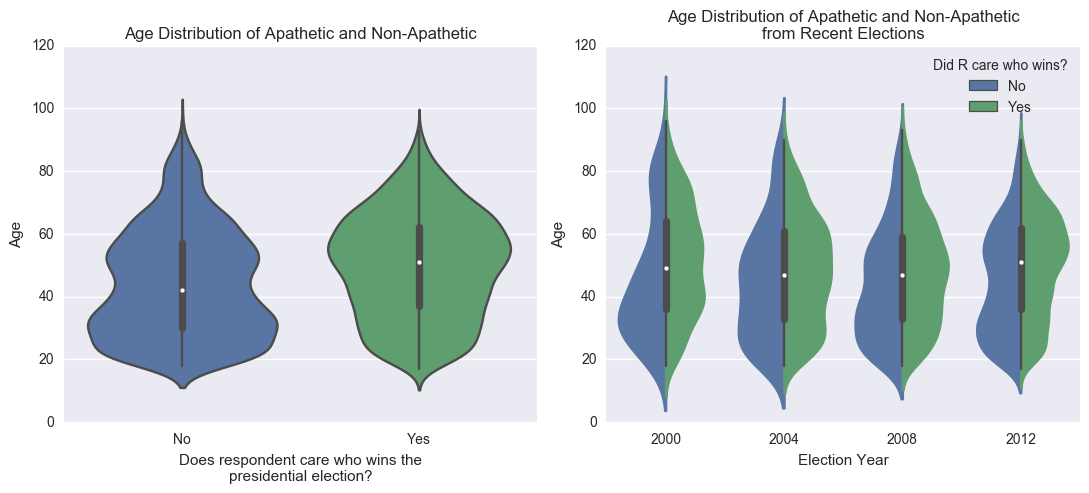

In [6]:
fig, axes = plt.subplots(1, 2, figsize = (11, 5))
df_temp = df[df.age > 10]
g = sns.violinplot(x = df_temp.VCF0311, y = df_temp.age, bw = .2, ax = axes[0])
g.set(title = 'Age Distribution of Apathetic and Non-Apathetic', xticklabels = ['No','Yes'])
g.set(xlabel = 'Does respondent care who wins the\npresidential election?', ylabel = 'Age')
g = sns.violinplot(x = df_temp.year, y = df_temp.age, hue = df_temp.VCF0311, ax = axes[1], split = True)
g.set(title = 'Age Distribution of Apathetic and Non-Apathetic\nfrom Recent Elections')
g.set(xlabel = 'Election Year', ylabel = 'Age', ylim = (0, 120))
handles, labels = g.get_legend_handles_labels()
g.legend(handles, ['No','Yes'], title = 'Did R care who wins?', loc = 0)
plt.tight_layout()

# Non-voters are more likely to believe their votes do not matter

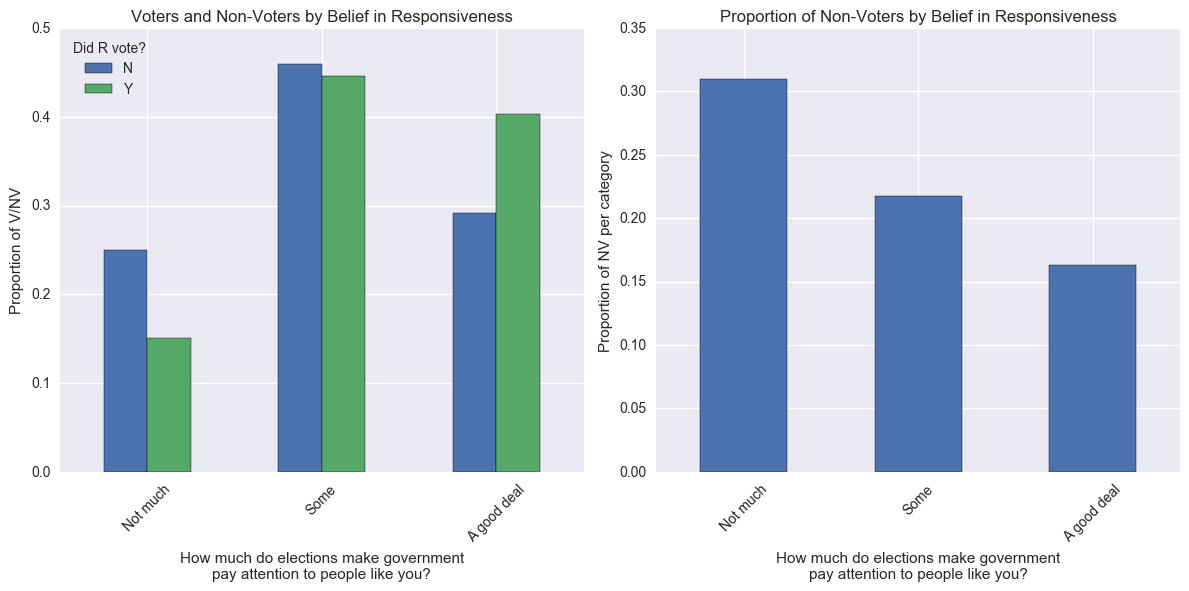

In [7]:
fig, axes = plt.subplots(1, 2, figsize = (12,6))
temp_df = df[:]
x_columns = ['Not much','Some','A good deal']

r = temp_df.groupby([temp_df.VCF0624,'VCF0702']).size()
r = r.unstack('VCF0702')
r.iloc[:,0] = r.iloc[:,0] / sum(r.iloc[:,0])
r.iloc[:,1] = r.iloc[:,1] / sum(r.iloc[:,1])
g = r.plot(kind = 'bar', ax = axes[0])
g.set(title = 'Voters and Non-Voters by Belief in Responsiveness',
      xlabel = 'How much do elections make government\npay attention to people like you?',
      ylabel = 'Proportion of V/NV', xticklabels = x_columns)
g.legend(title = 'Did R vote?', labels = ['N','Y'], loc = 2)
for each in g.get_xticklabels():
    each.set_rotation(45)

r = temp_df.groupby([temp_df.VCF0624,'VCF0702']).size()
r = r.unstack('VCF0702')
r['non_voter_proportion'] = r.iloc[:,0] / (r.iloc[:,1] + r.iloc[:,0])
g = r.non_voter_proportion.plot(kind = 'bar', ax = axes[1])
g.set(title = 'Proportion of Non-Voters by Belief in Responsiveness',
      xlabel = 'How much do elections make government\npay attention to people like you?',
      ylabel = 'Proportion of NV per category', xticklabels = x_columns)
plt.xticks(rotation = 45)

plt.tight_layout()

# How do voting levels differ for racial minorities?
From the data below, it appears that Hispanics do in fact have a higher non-voting rate than non-Hispanics by almost 15% and that this characterization is stable across different years. Breaking down the non-voting rate by election year, the data appears to conform with the fact that the 2012 election saw record Hispanic turnout. What remains notable, then, is the extent to which Hispanic turnout still lags behind the general population.

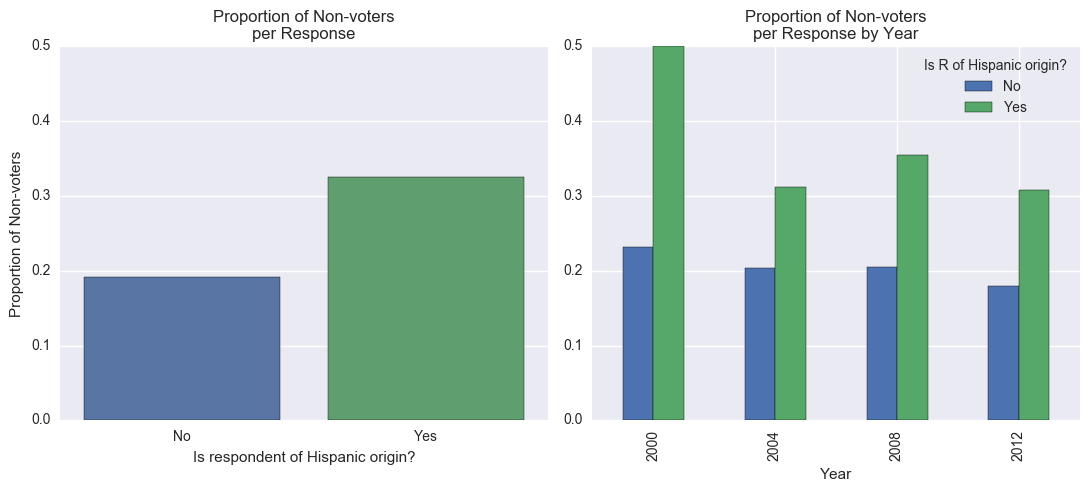

In [8]:
temp_df = df[:]
feature = 'VCF0108'

fig, axes = plt.subplots(1, 2, figsize = (11, 5))

n1 = sum(temp_df[feature] == 0); n2 = sum(temp_df[feature] == 1)
x1 = sum((temp_df[feature] == 0) & (temp_df['VCF0702'] == 0))
x2 = sum((temp_df[feature] == 1) & (temp_df['VCF0702'] == 0))
p1 = x1 / n1; p2 = x2 / n2
g = sns.barplot(['No','Yes'],[p1,p2], ax = axes[0])
g.set(title = 'Proportion of Non-voters\nper Response', xlabel = 'Is respondent of Hispanic origin?',
     ylabel = 'Proportion of Non-voters', ylim = (0,0.5))

temp_df = temp_df.groupby(['year','VCF0108','VCF0702']).size()
temp_df = temp_df.unstack('year')
p1 = temp_df.iloc[0,:] / (temp_df.iloc[0,:] + temp_df.iloc[1,:])
p2 = temp_df.iloc[2,:] / (temp_df.iloc[2,:] + temp_df.iloc[3,:])
p = pd.concat([p1, p2], axis = 1)
g = p.plot(kind = 'bar', ax = axes[1])
g.set(title = 'Proportion of Non-voters\nper Response by Year', xlabel = 'Year')
g.legend(title = 'Is R of Hispanic origin?', labels = ['No','Yes'])

plt.tight_layout()

While the 50% non-voting rate for Hispanics in 2000 may appear striking, it is important to note that Hispanics were relatively undersampled by this study during the 2000 election cycle.

In [9]:
temp_df.index = pd.MultiIndex(levels=[['No','Yes'],['No','Yes']],
           labels=[[0, 0, 1, 1], [0, 1, 0, 1]],
           names = ['Is R of Hispanic origin?','Did R vote?'])
temp_df

year                                  2000  2004  2008  2012
Is R of Hispanic origin? Did R vote?                        
No                       No            157   195   334   822
                         Yes           521   765  1295  3738
Yes                      No             18    29   163   281
                         Yes            18    64   297   633

Aside from African Americans, racial minorities have much higher non-voting rates, as shown by the data below. This conforms with publicly available data on minority turnout. It is important to bear in mind that the elections of 2008 and 2012, when Barack Obama was a presidential candidate, comprise the vast majority of data for this dataset. One might reasonably expect the turnout for African Americans to be lower in other election years.

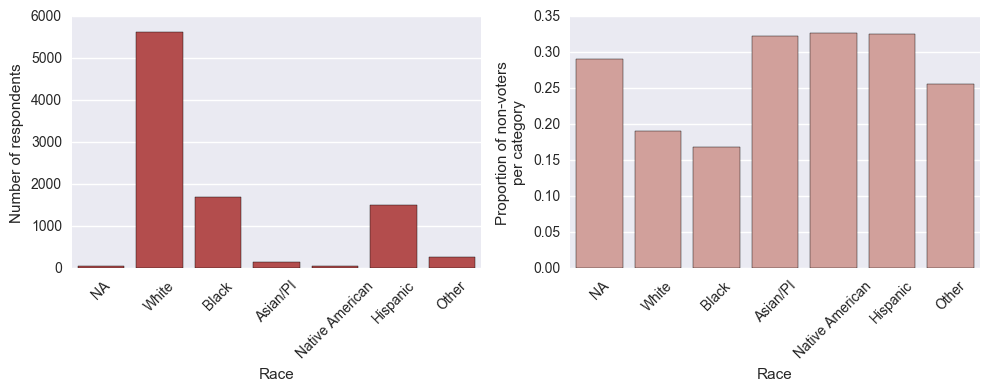

In [15]:
respondent_counts = []
NV_proportion = []
x = ['NA','White','Black','Asian/PI','Native American','Hispanic','Other']

first_index = df.columns.get_loc('VCF0105a_oh0')
last_index = df.columns.get_loc('VCF0105a_oh6')
for index in range(first_index, last_index + 1):
    respondent_counts.append(sum(df.iloc[:,index] == 1))
    NV_proportion.append(sum((df.iloc[:,index] == 1) & (df.VCF0702 == 0)) / respondent_counts[-1])

fig, axes = plt.subplots(1, 2, figsize = (10,4))
g1 = sns.barplot(x = x, y = respondent_counts, color = 'red',
            saturation = 0.4, ax = axes[0])
g1.set_ylabel('Number of respondents'); g1.set_xlabel('Race')
for each in g1.get_xticklabels():
    each.set_rotation(45)

g2 = sns.barplot(x = x, y = NV_proportion, color = 'salmon',
            saturation = 0.4, ax = axes[1])
g2.set_ylabel('Proportion of non-voters\nper category'); g2.set_xlabel('Race')
plt.xticks(rotation = 45)
plt.tight_layout()

### Hispanics are much younger than the non-Hispanic population

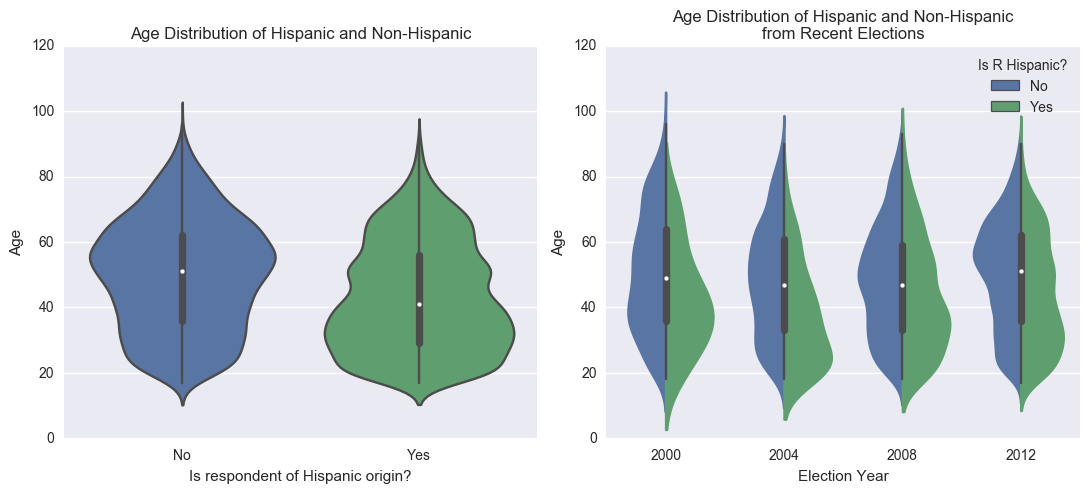

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (11, 5))
df_temp = df[df.age > 10]
g = sns.violinplot(x = df_temp.VCF0108, y = df_temp.age, bw = .2, ax = axes[0])
g.set(title = 'Age Distribution of Hispanic and Non-Hispanic', xticklabels = ['No','Yes'])
g.set(xlabel = 'Is respondent of Hispanic origin?', ylabel = 'Age')
g = sns.violinplot(x = df_temp.year, y = df_temp.age, hue = df_temp.VCF0108, ax = axes[1], split = True)
g.set(title = 'Age Distribution of Hispanic and Non-Hispanic\nfrom Recent Elections')
g.set(xlabel = 'Election Year', ylabel = 'Age', ylim = (0, 120))
handles, labels = g.get_legend_handles_labels()
g.legend(handles, ['No','Yes'], title = 'Is R Hispanic?', loc = 0)
plt.tight_layout()

# Education Level and Voting Propensity
Non-voters as a group tend to have lower levels of educational attainment.

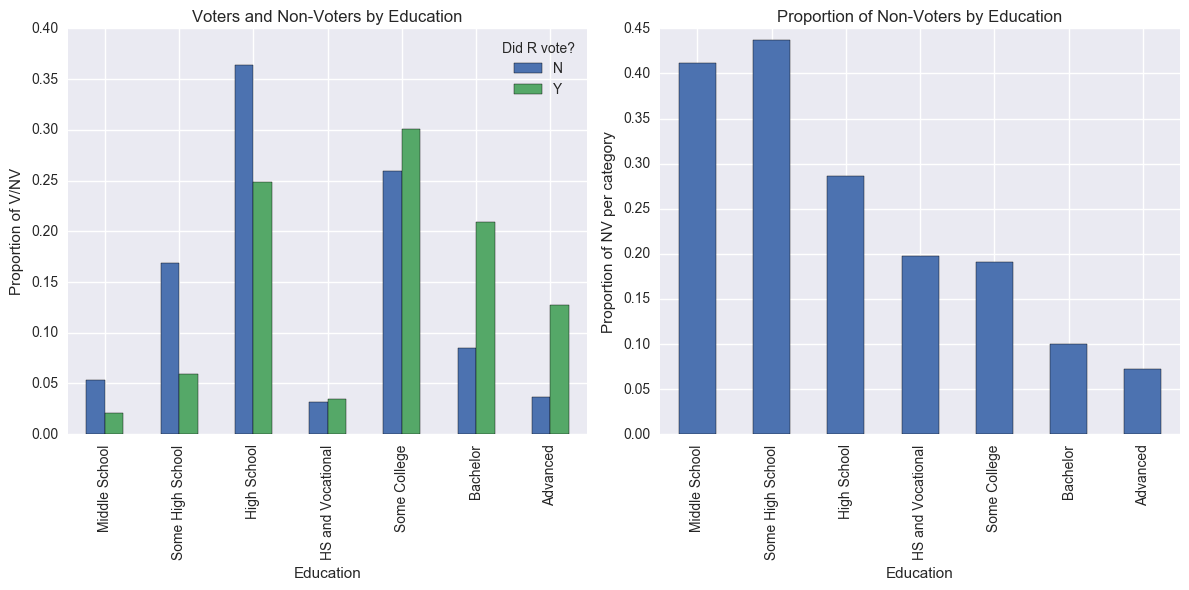

In [14]:
fig, axes = plt.subplots(1, 2, figsize = (12,6))
temp_df = df[:]
x_columns = ['Middle School','Some High School','High School','HS and Vocational',
                    'Some College','Bachelor','Advanced']

r = temp_df.groupby([temp_df.VCF0140a,'VCF0702']).size()
r = r.unstack('VCF0702')
r.iloc[:,0] = r.iloc[:,0] / sum(r.iloc[:,0])
r.iloc[:,1] = r.iloc[:,1] / sum(r.iloc[:,1])
g = r.plot(kind = 'bar', ax = axes[0])
g.set(title = 'Voters and Non-Voters by Education', xlabel = 'Education', ylabel = 'Proportion of V/NV',
     xticklabels = x_columns)
g.legend(title = 'Did R vote?', labels = ['N','Y'])

r = temp_df.groupby([temp_df.VCF0140a,'VCF0702']).size()
r = r.unstack('VCF0702')
r['non_voter_proportion'] = r.iloc[:,0] / (r.iloc[:,1] + r.iloc[:,0])
g = r.non_voter_proportion.plot(kind = 'bar', ax = axes[1])
g.set(title = 'Proportion of Non-Voters by Education', xlabel = 'Education', ylabel = 'Proportion of NV per category',
     xticklabels = x_columns)

plt.tight_layout()

# Social class and voting propensity
Given that non-voters tend to be less educated, it makes sense that non-voters as a group also tend to be lower on the socio-economic ladder than voters.

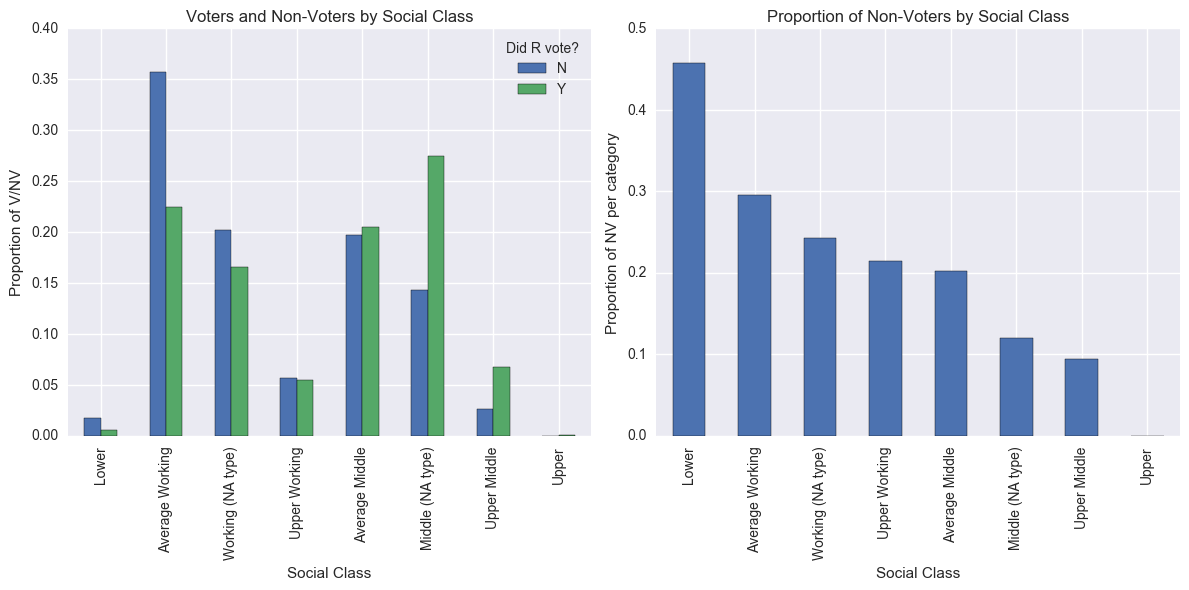

In [13]:
fig, axes = plt.subplots(1, 2, figsize = (12,6))
temp_df = df[:]
x_columns = ['Lower','Average Working','Working (NA type)','Upper Working','Average Middle','Middle (NA type)',
            'Upper Middle','Upper']

r = temp_df.groupby([temp_df.VCF0148,'VCF0702']).size()
r = r.unstack('VCF0702')
r = r.fillna(0)
r.iloc[:,0] = r.iloc[:,0] / sum(r.iloc[:,0])
r.iloc[:,1] = r.iloc[:,1] / sum(r.iloc[:,1])
g = r.plot(kind = 'bar', ax = axes[0])
g.set(title = 'Voters and Non-Voters by Social Class', xlabel = 'Social Class',
      ylabel = 'Proportion of V/NV', xticklabels = x_columns)
g.legend(title = 'Did R vote?', labels = ['N','Y'])

r = temp_df.groupby([temp_df.VCF0148,'VCF0702']).size()
r = r.unstack('VCF0702')
r = r.fillna(0)
r['non_voter_proportion'] = r.iloc[:,0] / (r.iloc[:,1] + r.iloc[:,0])
g = r.non_voter_proportion.plot(kind = 'bar', ax = axes[1])
g.set(title = 'Proportion of Non-Voters by Social Class', xlabel = 'Social Class',
      ylabel = 'Proportion of NV per category', xticklabels = x_columns)

plt.tight_layout()

# Home Ownership and Voting Propensity
Those who own a home are about 20% more likely to vote those who do not. This difference between proportions of non-voters among homeowners and non-homeowners could be attributed to the fact that younger voters are far less likely to own a home than older voters as well as the fact that non-voters tend to be less educated and therefore comprise a lower socio-economic class.

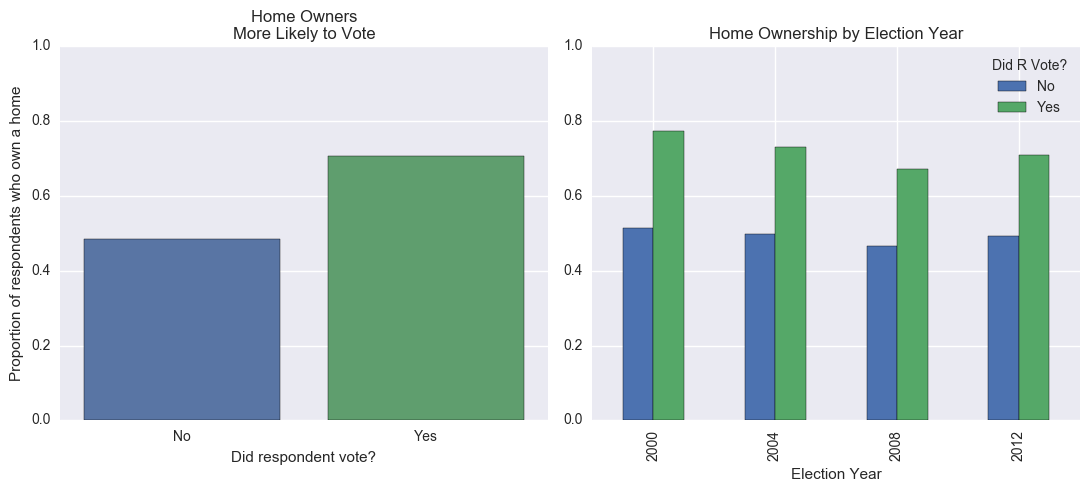

In [16]:
temp_df = df[:]
feature = 'VCF0702'

fig, axes = plt.subplots(1, 2, figsize = (11, 5))

n1 = sum(temp_df[feature] == 0); n2 = sum(temp_df[feature] == 1)
x1 = sum((temp_df[feature] == 0) & (temp_df['VCF0146'] == 1))
x2 = sum((temp_df[feature] == 1) & (temp_df['VCF0146'] == 1))
p1 = x1 / n1; p2 = x2 / n2
g = sns.barplot(['No','Yes'],[p1,p2], ax = axes[0])
g.set(title = 'Home Owners\nMore Likely to Vote', xlabel = 'Did respondent vote?',
     ylabel = 'Proportion of respondents who own a home', ylim = (0,1))

temp_df = temp_df.groupby(['year','VCF0702','VCF0146']).size()
temp_df = temp_df.unstack('year')
p1 = temp_df.iloc[1,:] / (temp_df.iloc[0,:] + temp_df.iloc[1,:])
p2 = temp_df.iloc[3,:] / (temp_df.iloc[2,:] + temp_df.iloc[3,:])
p = pd.concat([p1, p2], axis = 1)
g = p.plot(kind = 'bar', ax = axes[1])
g.set(title = 'Home Ownership by Election Year', xlabel = 'Election Year', ylim = (0,1))
g.legend(title = 'Did R Vote?', labels = ['No','Yes'], loc = 0)

plt.tight_layout()

# Church attendance and voting propensity
Non-voters as a group tend to attend church less frequently than do voters. This would also seem to support the notion that younger people tend to be less religious.

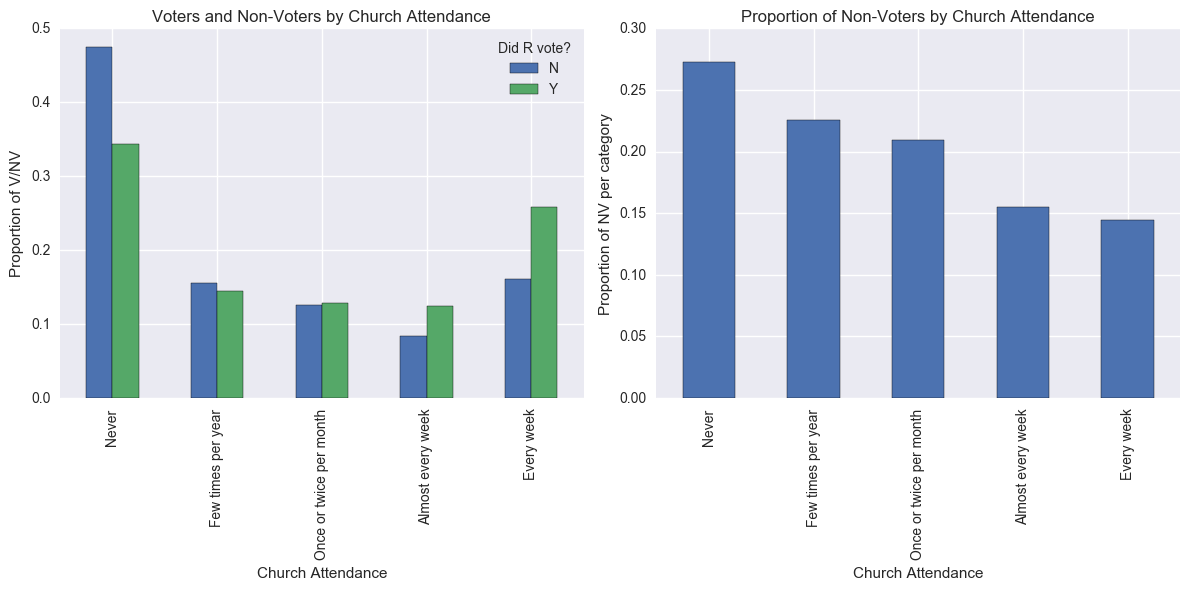

In [22]:
fig, axes = plt.subplots(1, 2, figsize = (12,6))
temp_df = df[:]
x_columns = ['Never','Few times per year','Once or twice per month','Almost every week',
                    'Every week']

r = temp_df.groupby([temp_df.VCF0130,'VCF0702']).size()
r = r.unstack('VCF0702')
r.iloc[:,0] = r.iloc[:,0] / sum(r.iloc[:,0])
r.iloc[:,1] = r.iloc[:,1] / sum(r.iloc[:,1])
g = r.plot(kind = 'bar', ax = axes[0])
g.set(title = 'Voters and Non-Voters by Church Attendance', xlabel = 'Church Attendance',
      ylabel = 'Proportion of V/NV', xticklabels = x_columns)
g.legend(title = 'Did R vote?', labels = ['N','Y'])

r = temp_df.groupby([temp_df.VCF0130,'VCF0702']).size()
r = r.unstack('VCF0702')
r['non_voter_proportion'] = r.iloc[:,0] / (r.iloc[:,1] + r.iloc[:,0])
g = r.non_voter_proportion.plot(kind = 'bar', ax = axes[1])
g.set(title = 'Proportion of Non-Voters by Church Attendance', xlabel = 'Church Attendance',
      ylabel = 'Proportion of NV per category', xticklabels = x_columns)

plt.tight_layout()

# Non-voters do not talk politics with others
The data confirms that of respondents who did not vote, a much greater proportion also did not discuss politics with friends or family. It is worth noting as well that there may be a growing trend across both voters and non-voters of not discussing politics with friends and family.

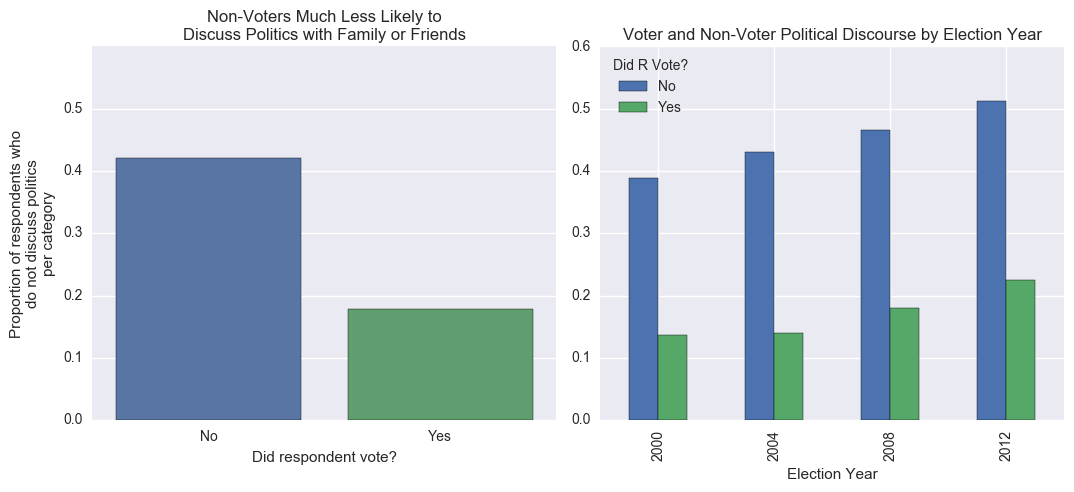

In [17]:
temp_df = df[:]
feature = 'VCF0702'
fig, axes = plt.subplots(1, 2, figsize = (11, 5))

n1 = sum(temp_df[feature] == 0); n2 = sum(temp_df[feature] == 1)
x1 = sum((temp_df[feature] == 0) & (temp_df['VCF0731'] == 0))
x2 = sum((temp_df[feature] == 1) & (temp_df['VCF0731'] == 0))
p1 = x1 / n1; p2 = x2 / n2
g = sns.barplot(['No','Yes'],[p1,p2], ax = axes[0])
g.set(title = 'Non-Voters Much Less Likely to\nDiscuss Politics with Family or Friends', 
      xlabel = 'Did respondent vote?', 
      ylabel = 'Proportion of respondents who\ndo not discuss politics\nper category', ylim = (0,0.6))

temp_df = temp_df.groupby(['year','VCF0702','VCF0731']).size()
temp_df = temp_df.unstack('year')
p1 = temp_df.iloc[0,:] / (temp_df.iloc[0,:] + temp_df.iloc[1,:])
p2 = temp_df.iloc[2,:] / (temp_df.iloc[2,:] + temp_df.iloc[3,:])
p = pd.concat([p1, p2], axis = 1)
g = p.plot(kind = 'bar', ax = axes[1])
g.set(title = 'Voter and Non-Voter Political Discourse by Election Year', xlabel = 'Election Year')
g.legend(title = 'Did R Vote?', labels = ['No','Yes'], loc = 0)

plt.tight_layout()

# Non-voters watch fewer TV programs about the election
Unsurprisingly, it appears that non-voters are more likely to avoid political TV programs than voters. Also interesting is the much higher proportions of voters and non-voters who do not watch political programming in 2012. Does highly partisan programming attract a more reliable and regular audience but repel more transient and less idealogical viewers?

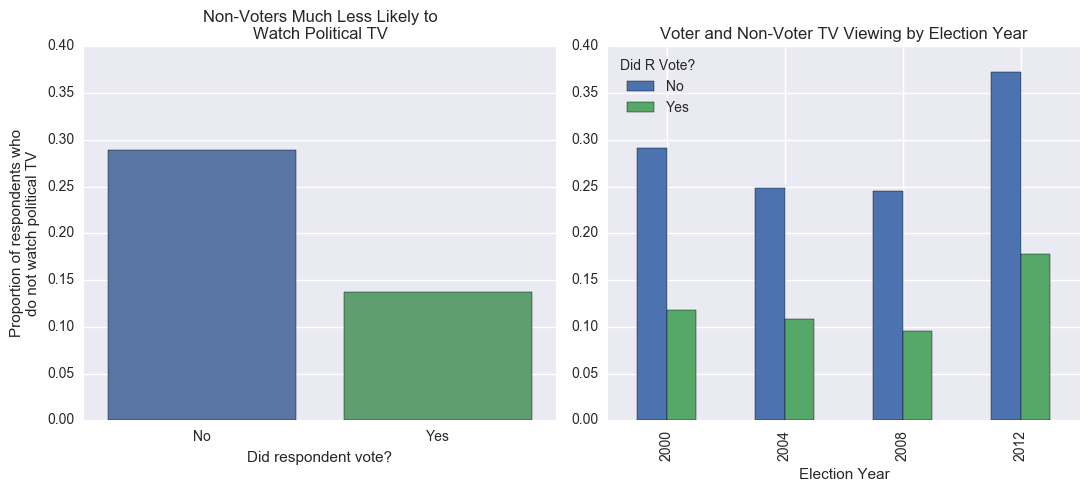

In [18]:
temp_df = df[:]
feature = 'VCF0702'

fig, axes = plt.subplots(1, 2, figsize = (11, 5))

n1 = sum(temp_df[feature] == 0); n2 = sum(temp_df[feature] == 1)
x1 = sum((temp_df[feature] == 0) & (temp_df['VCF0724'] == 0))
x2 = sum((temp_df[feature] == 1) & (temp_df['VCF0724'] == 0))
p1 = x1 / n1; p2 = x2 / n2
g = sns.barplot(['No','Yes'],[p1,p2], ax = axes[0])
g.set(title = 'Non-Voters Much Less Likely to\nWatch Political TV', xlabel = 'Did respondent vote?',
     ylabel = 'Proportion of respondents who\ndo not watch political TV', ylim = (0,0.4))

temp_df = temp_df.groupby(['year','VCF0702','VCF0724']).size()
temp_df = temp_df.unstack('year')
p1 = temp_df.iloc[0,:] / (temp_df.iloc[0,:] + temp_df.iloc[1,:])
p2 = temp_df.iloc[2,:] / (temp_df.iloc[2,:] + temp_df.iloc[3,:])
p = pd.concat([p1, p2], axis = 1)
g = p.plot(kind = 'bar', ax = axes[1])
g.set(title = 'Voter and Non-Voter TV Viewing by Election Year', xlabel = 'Election Year')
g.legend(title = 'Did R Vote?', labels = ['No','Yes'], loc = 0)

plt.tight_layout()

# Non-voters are largely non-partisan
It is often said that independents are the swing voters of each presidential election, but the data also shows that independents are also the most likely to sit out these elections.

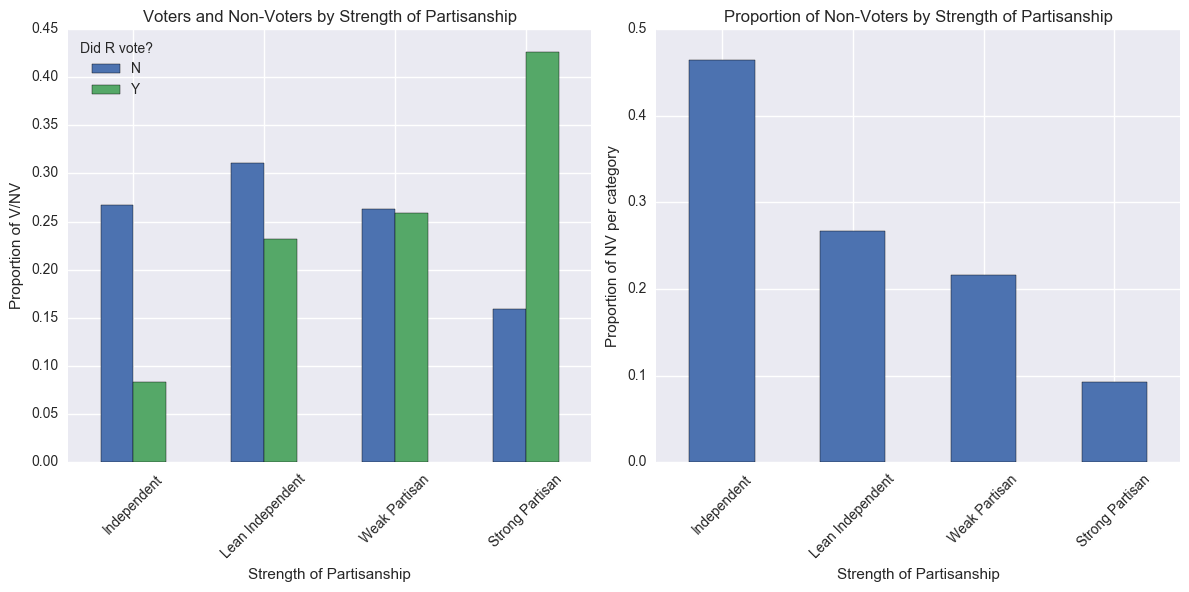

In [19]:
fig, axes = plt.subplots(1, 2, figsize = (12,6))
temp_df = df[:]
x_columns = ['Independent','Lean Independent','Weak Partisan','Strong Partisan']

r = temp_df.groupby([temp_df.VCF0305,'VCF0702']).size()
r = r.unstack('VCF0702')
r.iloc[:,0] = r.iloc[:,0] / sum(r.iloc[:,0])
r.iloc[:,1] = r.iloc[:,1] / sum(r.iloc[:,1])
g = r.plot(kind = 'bar', ax = axes[0])
g.set(title = 'Voters and Non-Voters by Strength of Partisanship', xlabel = 'Strength of Partisanship',
      ylabel = 'Proportion of V/NV', xticklabels = x_columns)
g.legend(title = 'Did R vote?', labels = ['N','Y'], loc = 0)
for each in g.get_xticklabels():
    each.set_rotation(45)

r = temp_df.groupby([temp_df.VCF0305,'VCF0702']).size()
r = r.unstack('VCF0702')
r['non_voter_proportion'] = r.iloc[:,0] / (r.iloc[:,1] + r.iloc[:,0])
g = r.non_voter_proportion.plot(kind = 'bar', ax = axes[1])
g.set(title = 'Proportion of Non-Voters by Strength of Partisanship', xlabel = 'Strength of Partisanship',
      ylabel = 'Proportion of NV per category', xticklabels = x_columns)
for each in g.get_xticklabels():
    each.set_rotation(45)

plt.tight_layout()

# Approval of President's Job Performance Equal Across Voters and Non-Voters
Rather interesting is the data that shows how views regarding the President's job performance give almost no indication as to whether someone will vote. This may simply be due to the fact that everyone has an opinion about the President, voters and non-voters alike.

The data showing presidential approval ratings by year tracks with publicly available data. For example, polls have shown that President Clinton left office in 2000 with approval ratings in the mid 60's while in the midst of the 2008 financial crisis, President Bush left office with an approval rating in the low 20's.

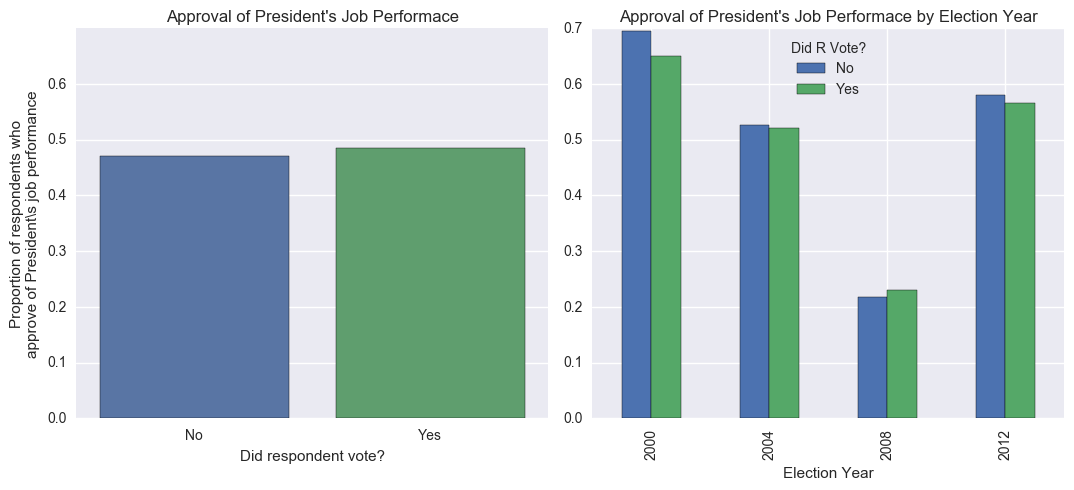

In [20]:
temp_df = df[:]
feature = 'VCF0702'

fig, axes = plt.subplots(1, 2, figsize = (11, 5))

n1 = sum(temp_df[feature] == 0); n2 = sum(temp_df[feature] == 1)
x1 = sum((temp_df[feature] == 0) & (temp_df['VCF0450'] == 1))
x2 = sum((temp_df[feature] == 1) & (temp_df['VCF0450'] == 1))
p1 = x1 / n1; p2 = x2 / n2
g = sns.barplot(['No','Yes'],[p1,p2], ax = axes[0])
g.set(title = 'Approval of President\'s Job Performace', xlabel = 'Did respondent vote?',
     ylabel = 'Proportion of respondents who\napprove of President\s job performance', ylim = (0,0.7))

temp_df = temp_df.groupby(['year','VCF0702','VCF0450']).size()
temp_df = temp_df.unstack('year')
p1 = temp_df.iloc[1,:] / (temp_df.iloc[0,:] + temp_df.iloc[1,:])
p2 = temp_df.iloc[3,:] / (temp_df.iloc[2,:] + temp_df.iloc[3,:])
p = pd.concat([p1, p2], axis = 1)
g = p.plot(kind = 'bar', ax = axes[1])
g.set(title = 'Approval of President\'s Job Performace by Election Year', xlabel = 'Election Year')
g.legend(title = 'Did R Vote?', labels = ['No','Yes'], loc = 0)

plt.tight_layout()

# Perceived Closeness of Presidential Race in Respondent's State
Also surprising is the data that shows how the perceived closeness of the presidential race in the respondent's state is equal for voters and non-voters. One might have expected that people would be more motivated to vote if the election was going to be close in their state, but the data contradicts this notion.

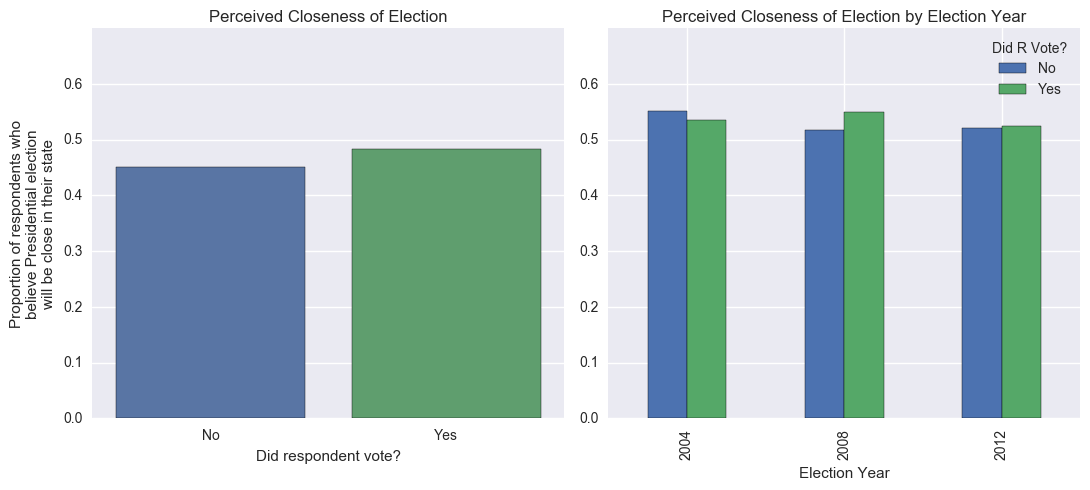

In [21]:
temp_df = df[:]
feature = 'VCF0702'

fig, axes = plt.subplots(1, 2, figsize = (11, 5))

n1 = sum(temp_df[feature] == 0); n2 = sum(temp_df[feature] == 1)
x1 = sum((temp_df[feature] == 0) & (temp_df['VCF9029'] == 1))
x2 = sum((temp_df[feature] == 1) & (temp_df['VCF9029'] == 1))
p1 = x1 / n1; p2 = x2 / n2
g = sns.barplot(['No','Yes'],[p1,p2], ax = axes[0])
g.set(title = 'Perceived Closeness of Election', xlabel = 'Did respondent vote?',
     ylabel = 'Proportion of respondents who\nbelieve Presidential election\nwill be close in their state',
      ylim = (0,0.7))

temp_df = temp_df.groupby(['year','VCF0702','VCF9029']).size()
temp_df = temp_df.unstack('year')
p1 = temp_df.iloc[1,:] / (temp_df.iloc[0,:] + temp_df.iloc[1,:])
p2 = temp_df.iloc[3,:] / (temp_df.iloc[2,:] + temp_df.iloc[3,:])
p = pd.concat([p1, p2], axis = 1)
g = p.plot(kind = 'bar', ax = axes[1])
g.set(title = 'Perceived Closeness of Election by Election Year', xlabel = 'Election Year', ylim = (0,0.7))
g.legend(title = 'Did R Vote?', labels = ['No','Yes'], loc = 0)

plt.tight_layout()

# How politically knowledgable are non-voters compared to voters?
The ANES survey asks interviewees a small battery of questions to assess their political knowledge. The plots below show the proportion of non-voters within each response group. In some cases, the more "incorrect" the respondent, the more likely he is to be a non-voter. In other cases, the answer group with the highest proportion of non-voters happens to be the neutral answer, such as answering "4 - moderate" to "How liberal/conservative is the Democratic Party?"

Also notable is the significant difference in the proportions of non-voters that answered "Don't know" to a question compared to those who gave one of the prescribed ordinal responses.

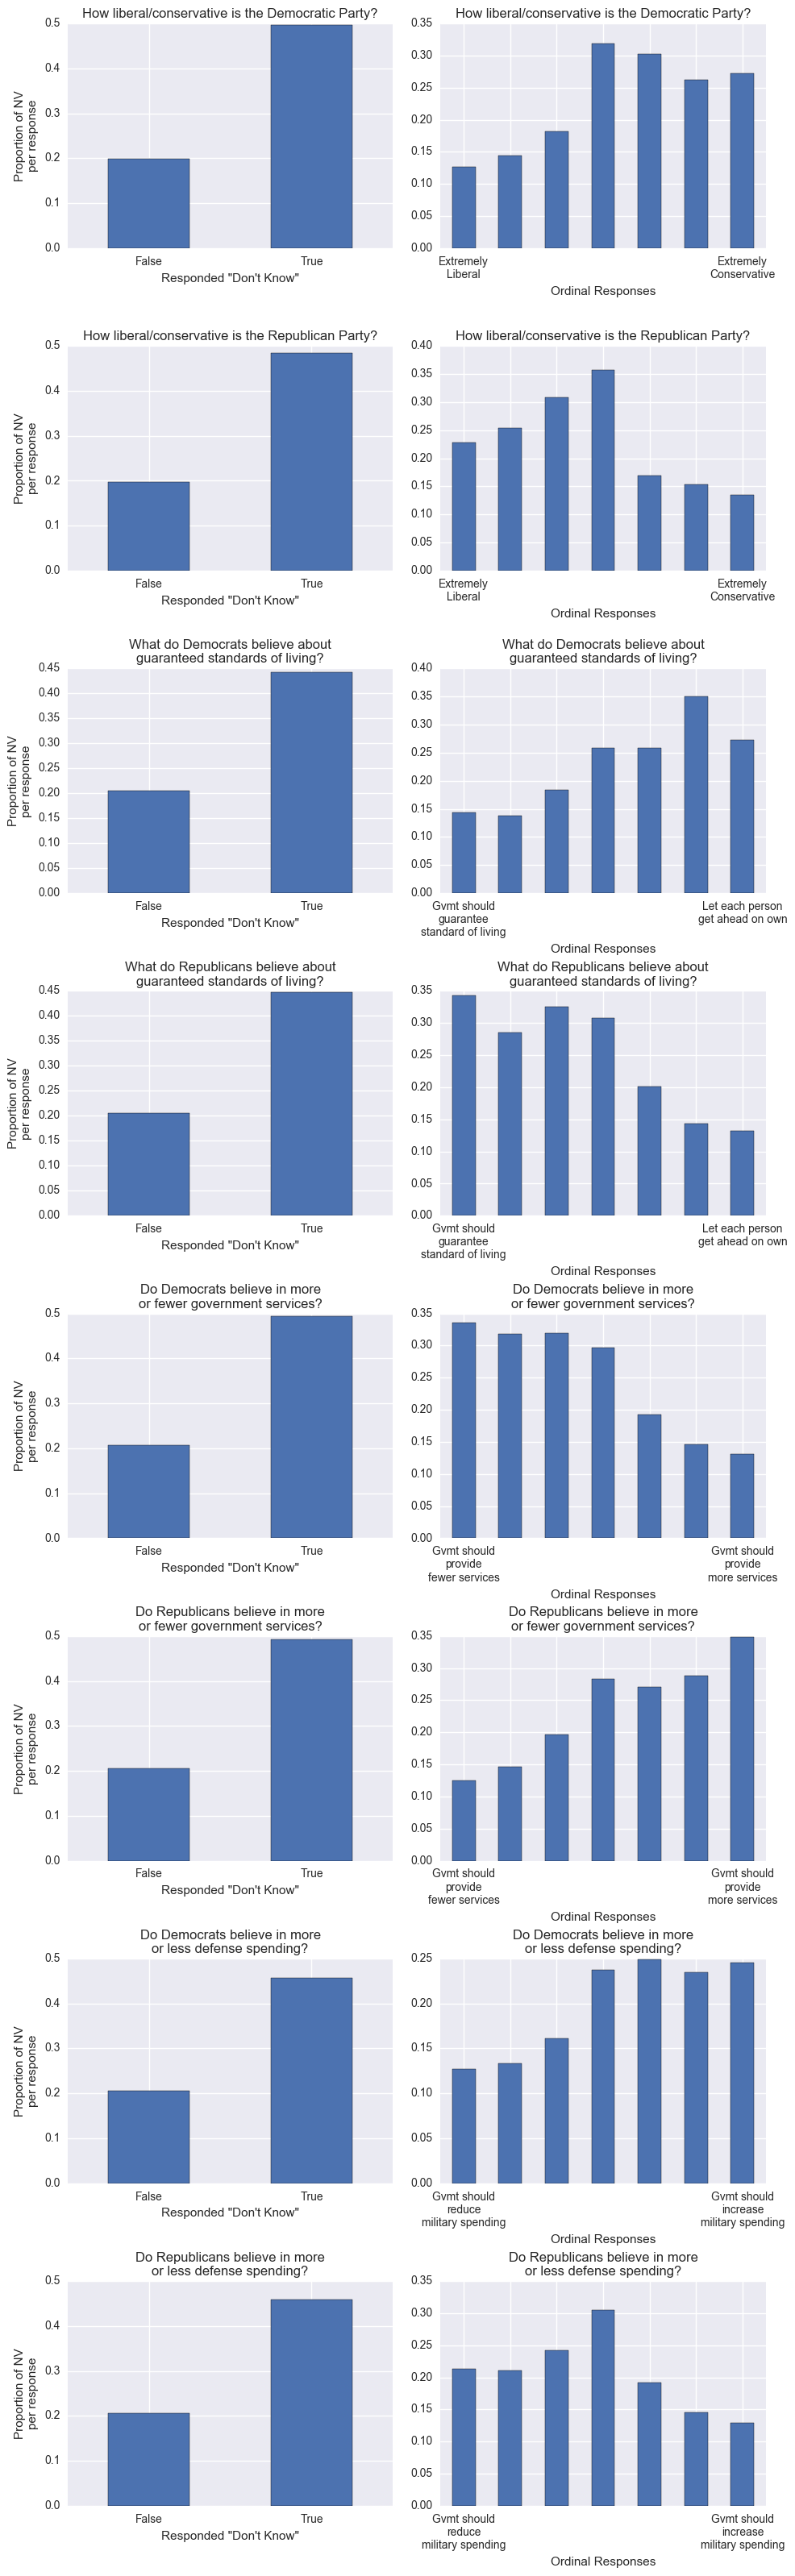

In [22]:
temp_df = df[:]

plot_titles = ['How liberal/conservative is the Democratic Party?',
               'How liberal/conservative is the Republican Party?',
               'What do Democrats believe about\nguaranteed standards of living?',
               'What do Republicans believe about\nguaranteed standards of living?',
               'Do Democrats believe in more\nor fewer government services?',
               'Do Republicans believe in more\nor fewer government services?',
               'Do Democrats believe in more\nor less defense spending?',
               'Do Republicans believe in more\nor less defense spending?']

firstIndex = temp_df.columns.get_loc('VCF0503_dk')
lastIndex = temp_df.columns.get_loc('VCF0550')
num_plots = lastIndex - firstIndex + 1
fig, axes = plt.subplots(num_plots // 2, 2, figsize = (10, 2 * num_plots))

for axesIndex, index in zip(range(0, num_plots), range(firstIndex, lastIndex + 1)):
    
    r = temp_df.groupby([temp_df.columns[index],'VCF0702']).size()
    r = r.unstack('VCF0702')
    r['non_voter_proportion'] = r.iloc[:,0] / (r.iloc[:,1] + r.iloc[:,0])
    g = r.non_voter_proportion.plot(kind = 'bar', ax = axes[axesIndex // 2][axesIndex % 2])
    g.set_title(plot_titles[axesIndex // 2])
    for each in g.get_xticklabels():
        each.set_rotation(0)
    if axesIndex % 2 == 0:
        g.set_ylabel('Proportion of NV\nper response')
        g.set_xlabel('Responded \"Don\'t Know\"')
    else:
        g.set_xlabel('Ordinal Responses')
        
axes[0][1].set_xticklabels(['Extremely\nLiberal','','','','','','Extremely\nConservative'])
axes[1][1].set_xticklabels(['Extremely\nLiberal','','','','','','Extremely\nConservative'])
axes[2][1].set_xticklabels(['Gvmt should\nguarantee\nstandard of living','','','','','',
                            'Let each person\nget ahead on own'])
axes[3][1].set_xticklabels(['Gvmt should\nguarantee\nstandard of living','','','','','',
                            'Let each person\nget ahead on own'])
axes[4][1].set_xticklabels(['Gvmt should\nprovide\nfewer services','','','','','',
                            'Gvmt should\nprovide\nmore services'])
axes[5][1].set_xticklabels(['Gvmt should\nprovide\nfewer services','','','','','',
                            'Gvmt should\nprovide\nmore services'])
axes[6][1].set_xticklabels(['Gvmt should\nreduce\nmilitary spending','','','','','',
                            'Gvmt should\nincrease\nmilitary spending'])
axes[7][1].set_xticklabels(['Gvmt should\nreduce\nmilitary spending','','','','','',
                            'Gvmt should\nincrease\nmilitary spending'])

#g.get_xticklabels()[0].set_position([1,-0.06])
#g.get_xticklabels()[6].set_position([1,-0.06])
    
plt.tight_layout()
fig.set_label('Test')

### It stands to reason then that the more a respondent answers "don't know" to these types of questions, the more likely he is to be a non-voter.

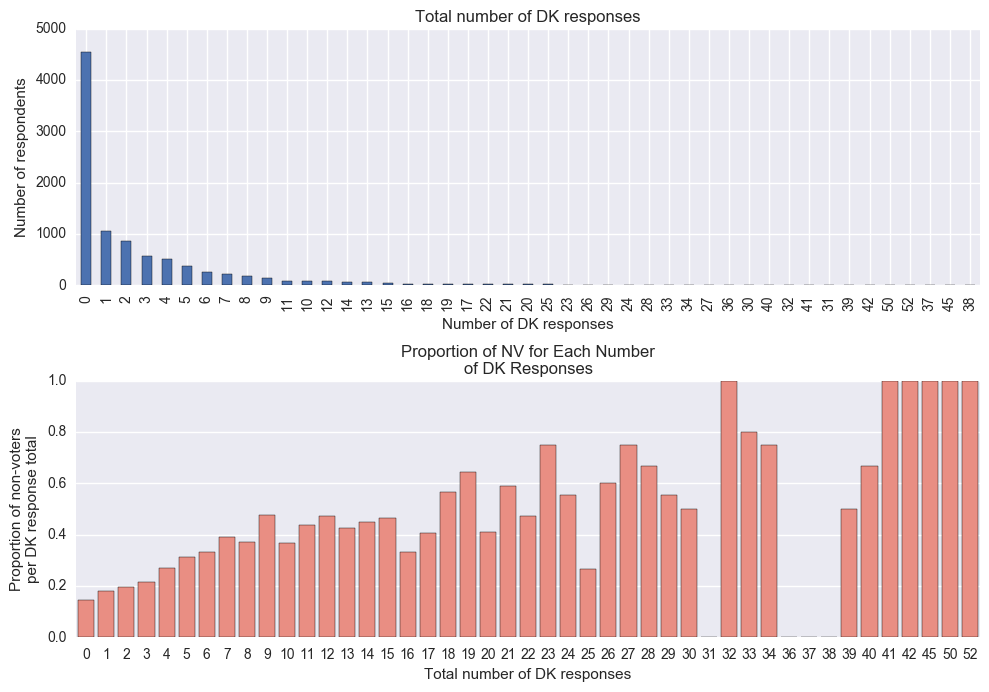

In [23]:
fig, axes = plt.subplots(2,1,figsize = (10,7))

dksum_df = df.loc[:,df.columns.str.contains('dk')].astype(int)
dksum_df['total'] = dksum_df.iloc[:,1:].sum(axis = 1)
g = dksum_df.total.value_counts().plot(kind = 'bar', ax = axes[0])
g.set_title('Total number of DK responses')
g.set_xlabel('Number of DK responses')
g.set_ylabel('Number of respondents')

dksum_df = pd.concat([dksum_df, df.VCF0702], axis = 1)
dksum_df = dksum_df.groupby(['total','VCF0702']).size()
dksum_df = dksum_df.unstack('VCF0702')
dksum_df = dksum_df.fillna(0)
dksum_df['nonvote_proportion'] = dksum_df.iloc[:,0] / (dksum_df.iloc[:,0] + dksum_df.iloc[:,1])

g = sns.barplot(x = dksum_df.index, y = dksum_df.nonvote_proportion, color = 'salmon', ax = axes[1])
g.set(title = 'Proportion of NV for Each Number\nof DK Responses', xlabel = 'Total number of DK responses',
     ylabel = 'Proportion of non-voters\nper DK response total')
plt.tight_layout()

# What sorts of spending priorities do non-voters support as a group?
Troublingly for Democrats, it seems that the people who tend to stay home on election day also happen to be people who support their policy priorities. The plots below show the proportion of non-voters for each response of a spending priority question, with smaller numbers indicating support for increasing spending and larger numbers indicating support for decreasing spending.

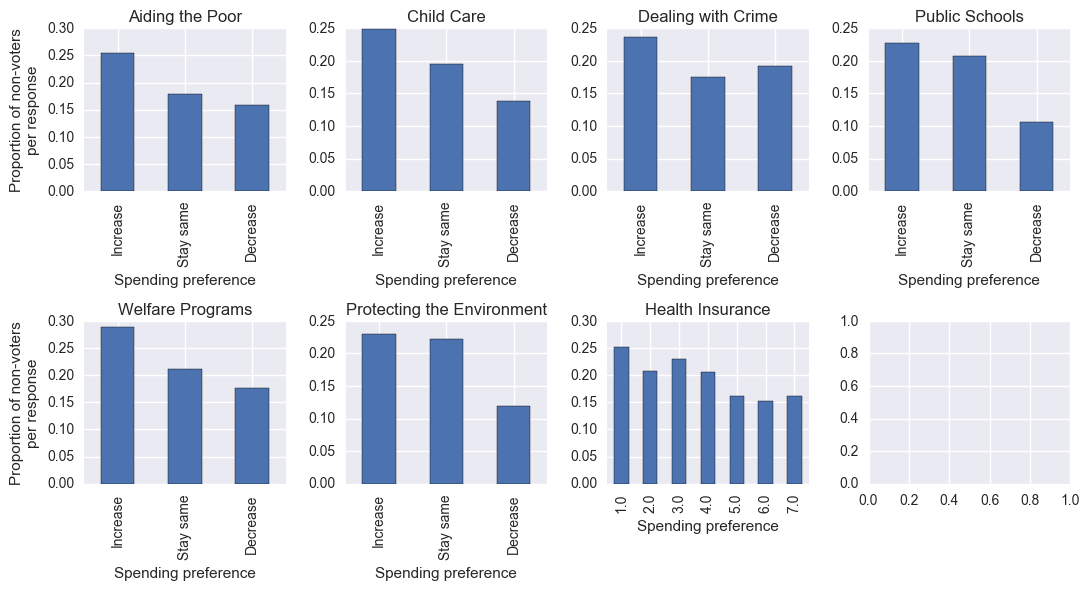

In [55]:
temp_df = df[:]

firstIndex = temp_df.columns.get_loc('VCF0886')
lastIndex = temp_df.columns.get_loc('VCF9047')

temp_df = temp_df.iloc[:,firstIndex:lastIndex+1]
temp_df = temp_df.iloc[:, ~temp_df.columns.str.contains('dk')]
temp_df = pd.concat([temp_df, df.VCF0702, df.VCF0806],axis = 1)
firstIndex = temp_df.columns.get_loc('VCF0886')
lastIndex = temp_df.columns.get_loc('VCF9047')

num_plots = lastIndex - firstIndex + 1
fig, axes = plt.subplots(num_plots // 4 + 1, 4, figsize = (11, num_plots))
plot_titles = ['Aiding the Poor','Child Care','Dealing with Crime','Public Schools','Welfare Programs',
              'Protecting the Environment']

for axesIndex, index in zip(range(0, num_plots), range(firstIndex, lastIndex + 1)):
    
    r = temp_df.groupby([temp_df.columns[index],'VCF0702']).size()
    r = r.unstack('VCF0702')
    r['non_voter_proportion'] = r.iloc[:,0] / (r.iloc[:,1] + r.iloc[:,0])
    g = r.non_voter_proportion.plot(kind = 'bar', ax = axes[axesIndex // 4][axesIndex % 4])
    g.set(title = plot_titles[axesIndex], xlabel = 'Spending preference',
          xticklabels = ['Increase','Stay same','Decrease'])
    if axesIndex % 4 == 0:
        g.set_ylabel('Proportion of non-voters\nper response')

axesIndex = axesIndex + 1
r = temp_df.groupby([temp_df.VCF0806,'VCF0702']).size()
r = r.unstack('VCF0702')
r['non_voter_proportion'] = r.iloc[:,0] / (r.iloc[:,1] + r.iloc[:,0])
g = r.non_voter_proportion.plot(kind = 'bar', ax = axes[axesIndex // 4][axesIndex % 4])
g.set(title = 'Health Insurance', xlabel = 'Spending preference')
        
plt.tight_layout()

The above data would not be terribly interesting, however, if not many people support increases to federal programs. So a better way to examine whether non-voters truly skew pro-spending is to plot the proportions voters and non-voters (out of total voters and non-voters, respectively) that picked each response.

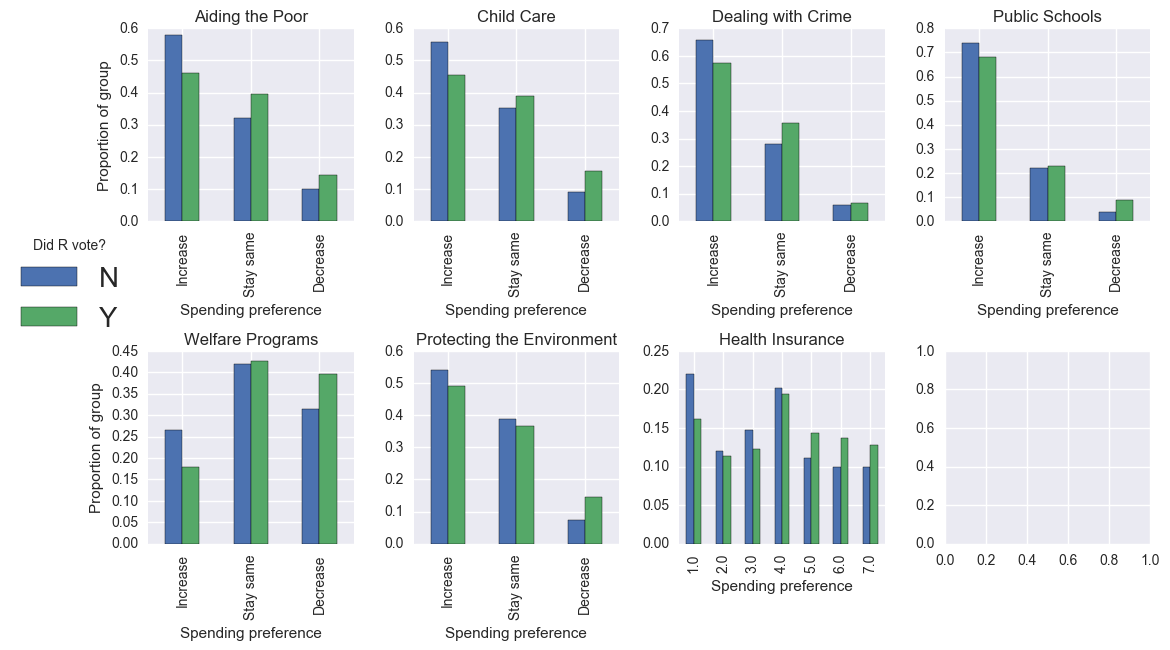

In [53]:
temp_df = df[:]

firstIndex = temp_df.columns.get_loc('VCF0886')
lastIndex = temp_df.columns.get_loc('VCF9047')

temp_df = temp_df.iloc[:,firstIndex:lastIndex+1]
temp_df = temp_df.iloc[:, ~temp_df.columns.str.contains('dk')]
temp_df = pd.concat([temp_df, df.VCF0702, df.VCF0806],axis = 1)
firstIndex = temp_df.columns.get_loc('VCF0886')
lastIndex = temp_df.columns.get_loc('VCF9047')

num_plots = lastIndex - firstIndex + 1
fig, axes = plt.subplots(num_plots // 4 + 1, 4, figsize = (11, 1.1 * num_plots))
plot_titles = ['Aiding the Poor','Child Care','Dealing with Crime','Public Schools','Welfare Programs',
              'Protecting the Environment']

for axesIndex, index in zip(range(0, num_plots), range(firstIndex, lastIndex + 1)):
    
    r = temp_df.groupby([temp_df.columns[index],'VCF0702']).size()
    r = r.unstack('VCF0702')
    r.iloc[:,0] = r.iloc[:,0] / sum(r.iloc[:,0])
    r.iloc[:,1] = r.iloc[:,1] / sum(r.iloc[:,1])
    g = r.plot(kind = 'bar', ax = axes[axesIndex // 4][axesIndex % 4])
    g.set(title = plot_titles[axesIndex], xlabel = 'Spending preference',
          xticklabels = ['Increase','Stay same','Decrease'])
    g.legend(title = 'Did R vote?', labels = ['N','Y'], bbox_to_anchor=(-0.02, 0.04), prop = {'size': 20})
    if axesIndex % 4 == 0:
        g.set_ylabel('Proportion of group')
    if axesIndex != 0:
        g.legend_.remove()

axesIndex = axesIndex + 1
r = temp_df.groupby([temp_df.VCF0806,'VCF0702']).size()
r = r.unstack('VCF0702')
r.iloc[:,0] = r.iloc[:,0] / sum(r.iloc[:,0])
r.iloc[:,1] = r.iloc[:,1] / sum(r.iloc[:,1])
g = r.plot(kind = 'bar', ax = axes[axesIndex // 4][axesIndex % 4])
g.set(title = 'Health Insurance', xlabel = 'Spending preference')
g.legend(title = 'Did R vote?', labels = ['N','Y'])
g.legend_.remove()
        
plt.tight_layout()

Concretely, we can see that non-voters do in fact tend to favor increased federal spending on many Democratic priorities. This is particularly notable in light of the fact that a Democrat won the presidential election of 2012, which is far overrepresented in the sample of interest.

# An Aside: Partisanship in America
### (from this point forward, all analyses incorporates weighted sample data)
The ANES survey contains a battery of "Thermometer" questions that measure the respondent's sentiment towards certain individuals, groups, and institutions. The respondent is asked to rate a thermometer subject on a scale from 0 to 100, with 0 indictating the most negative sentiment possible, and 100 indicating the most positive sentiment possible.

Below is a correlation plot of all thermometer variables.

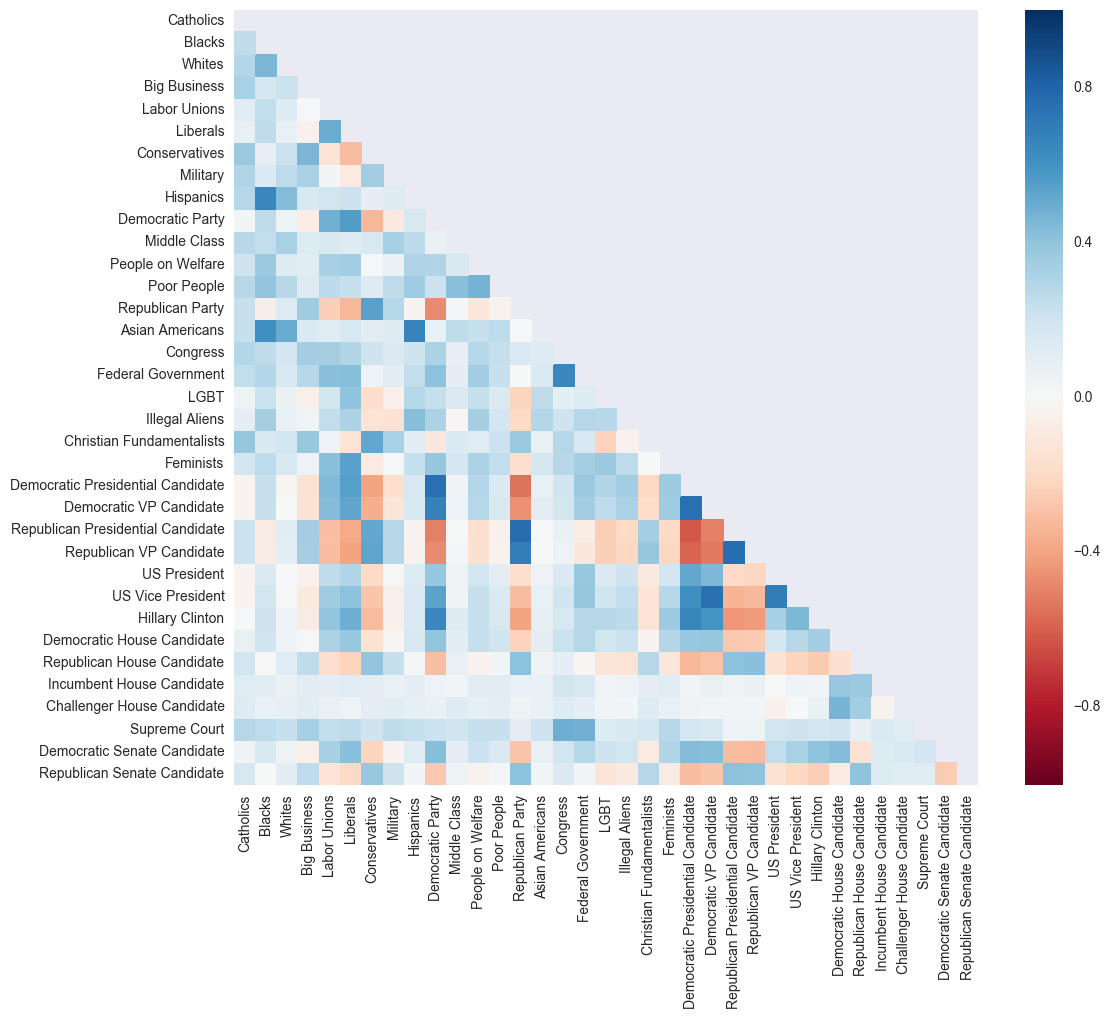

In [18]:
firstIndex = df.columns.get_loc('VCF0204')
lastIndex = df.columns.get_loc('VCF9057')
weightIndex = df.columns.get_loc('weight')

numerical_df = df.iloc[:,range(firstIndex,lastIndex+1,2)]
numerical_df = pd.concat([numerical_df, df.iloc[:,df.columns.get_loc('VCF0649'):df.columns.get_loc('VCF1016')]], axis = 1)
#numerical_df = numerical_df.drop(['VCF0656_dk','VCF0801_dk','VCF0649','VCF0656','VCF0723','VCF0733','VCF0801'], axis = 1)
numerical_df = numerical_df.drop(['VCF0801_dk','VCF0649','VCF0656','VCF0723','VCF0733','VCF0801'], axis = 1)
numerical_df = numerical_df.drop(['VCF1015','VCF0138','VCF0291','VCF0413','VCF0415'], axis = 1)
numerical_df = numerical_df.fillna(50)

from helpers import weighted_stats as ws

columns = ['Catholics','Blacks','Whites','Big Business',
            'Labor Unions','Liberals','Conservatives',
            'Military','Hispanics','Democratic Party',
            'Middle Class','People on Welfare','Poor People',
            'Republican Party','Asian Americans','Congress',
            'Federal Government','LGBT','Illegal Aliens',
            'Christian Fundamentalists','Feminists',
            'Democratic Presidential Candidate','Democratic VP Candidate',
            'Republican Presidential Candidate','Republican VP Candidate',
            'US President','US Vice President','Hillary Clinton',
            'Democratic House Candidate', 'Republican House Candidate',
            'Incumbent House Candidate', 'Challenger House Candidate',
            'Supreme Court','Democratic Senate Candidate',
            'Republican Senate Candidate']
                     
fig, axes = plt.subplots(1,1,figsize = (12,10))
#numerical_df = numerical_df.loc[:,np.logical_not(numerical_df.columns.str.contains('Index'))]
#corr = numerical_df.corr()
corr = ws.weighted_correlation_matrix(np.array(numerical_df), df.weight)
corr = pd.DataFrame(corr, columns = columns, index = columns)
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, ax = axes, mask = mask, cmap = 'RdBu')

### Identity vs. Ideology
One expects in a country as seemingly politically polarized as the United States to see significant anti-correlated pairs of thermometer variables, but the data tells a different story. While it is unsurprising to see that the Democratic and Republican presidential candidates form the most anti-correlated pair, the negative correlation is only moderate at best. More significantly, the correlation is signifcantly weaker for the major political parties themselves, and weaker even still, to the point of statistical insignificance, for the major political ideologies (liberals vs. conservatives). This data, then, would support the theory that politics is far less about issues or even ideology and far more about what some have called identity and "tribalism." 

Furthermore, while one expects Senate and House races to be less polarizing than the headline-grabbing presidential race, it is surprisingly how much less correlated the Senate and House candidates are to each other. This suggests a significant number of non-ideological Americans who become temporarily polarized during presidential elections but do not remain so.

In [19]:
numerical_df = df[:]
numerical_df = numerical_df.fillna(50)
weights = df.weight
corr_list = []
corr_list.append(['Big Business vs Labor Unions',
                  ws.weighted_correlation(numerical_df.VCF0209, numerical_df.VCF0210, weights)])
corr_list.append(['Liberals vs Conservatives',
                  ws.weighted_correlation(numerical_df.VCF0211, numerical_df.VCF0212, weights)])
corr_list.append(['Democratic vs Republican Party',
                  ws.weighted_correlation(numerical_df.VCF0218, numerical_df.VCF0224, weights)])
corr_list.append(['LGBT vs Christian Fundamentalists',
                  ws.weighted_correlation(numerical_df.VCF0232, numerical_df.VCF0234, weights)])
corr_list.append(['Democratic vs Republican Pres Candidate',
                  ws.weighted_correlation(numerical_df.VCF0424, numerical_df.VCF0426, weights)])
corr_list.append(['Democratic vs Republican VP Candidate',
                  ws.weighted_correlation(numerical_df.VCF0425, numerical_df.VCF0427, weights)])
corr_list.append(['Democratic vs Republican House Candidate',
                  ws.weighted_correlation(numerical_df.VCF0906, numerical_df.VCF0907, weights)])
corr_list.append(['Democratic vs Republican Senate Candidate',
                  ws.weighted_correlation(numerical_df.VCF9056, numerical_df.VCF9057, weights)])
corr_list.sort(key = lambda x: x[1])
corr_df = pd.DataFrame(corr_list)
corr_df.columns = ['Thermometer Pair','Correlation Coefficient']
corr_df

,Thermometer Pair,Correlation Coefficient
0,Democratic vs Republican Pres Candidate,-0.617542
1,Democratic vs Republican VP Candidate,-0.530565
2,Democratic vs Republican Party,-0.469287
3,Liberals vs Conservatives,-0.306816
4,Democratic vs Republican Senate Candidate,-0.254249
5,LGBT vs Christian Fundamentalists,-0.230465
6,Democratic vs Republican House Candidate,-0.159287
7,Big Business vs Labor Unions,0.015196


# Thermometer Intensity and Voting Propensity
If non-voters as a group are more apathetic and less informed than voters, then one might reasonably expect non-voters to be less opinionated. The thermometer variables from the previous section can be converted into intensity variables by taking the absolute value of the distance from the most neutral value, 50. This quantity is then divided by 5 so that all thermometer intensity values range from **0 to 5**.

In [51]:
firstIndex = df.columns.get_loc('VCF0204')
lastIndex = df.columns.get_loc('VCF9057')
targetIndex = df.columns.get_loc('VCF0702')

temp_df = df.iloc[:,range(firstIndex,lastIndex+1,2)]

temp_df.columns = ['Thermometer: Catholics','Thermometer: Blacks','Thermometer: Whites','Thermometer: Big Business',
                       'Thermometer: Labor Unions','Thermometer: Liberals','Thermometer: Conservatives',
                        'Thermometer: Military','Thermometer: Hispanics','Thermometer: Democratic Party',
                        'Thermometer: Middle Class','Thermometer: People on Welfare','Thermometer: Poor People',
                       'Thermometer: Republican Party','Thermometer: Asian Americans','Thermometer: Congress',
                       'Thermometer: Federal Government','Thermometer: LGBT','Thermometer: Illegal Aliens',
                       'Thermometer: Christian Fundamentalists','Thermometer: Feminists', 'Index: Major Parties',
                       'Index: Presidential Candidates', 'Index: VP Candidates',
                       'Thermometer: Democratic Presidential Candidate','Thermometer: Democratic VP Candidate',
                       'Thermometer: Republican Presidential Candidate','Thermometer: Republican VP Candidate',
                       'Thermometer: US President','Thermometer: US Vice President','Thermometer: Hillary Clinton',
                        'Thermometer: Democratic House Candidate', 'Thermometer: Republican House Candidate',
                        'Thermometer: Incumbent House Candidate', 'Thermometer: Challenger House Candidate',
                       'Thermometer: Supreme Court','Thermometer: Democratic Senate Candidate',
                       'Thermometer: Republican Senate Candidate']

temp_df = pd.concat([temp_df, df.weight], axis = 1)
temp_df = temp_df.iloc[:,~temp_df.columns.str.contains('Index')]
temp_df = temp_df.fillna(50)

firstIndex = temp_df.columns.get_loc('Thermometer: Catholics')
lastIndex = temp_df.columns.get_loc('Thermometer: Republican Senate Candidate')
num_plots = lastIndex - firstIndex + 1

target0_df = temp_df[df.iloc[:,targetIndex] == 0]
target1_df = temp_df[df.iloc[:,targetIndex] == 1]

p_list = []

for axesIndex, index in zip(range(0, num_plots), range(firstIndex, lastIndex + 1)):
    
    data1 = abs(target0_df.iloc[:,index] - 50) // 10
    data2 = abs(target1_df.iloc[:,index] - 50) // 10
    w1 = target0_df.weight
    w2 = target1_df.weight
    mu1 = ws.weighted_mean(data1, w1)
    mu2 = ws.weighted_mean(data2, w2)
    n1 = len(data1)
    n2 = len(data2)
    v1 = ws.weighted_variance(data1, w1)
    v2 = ws.weighted_variance(data2, w2)
    d = mu1-mu2

    t = d / np.sqrt(v1/n1 + v2/n2)
    p = (1 - stats.t.cdf(abs(t), min(n1,n2)-1)) * 2
    p_list.append([d,p,temp_df.columns[index]])

p_list.sort(key = lambda x: abs(x[0]), reverse = True)
diff_df = pd.DataFrame(p_list)
diff_df.columns = ['Difference Thermometer Intensity','P-value','Variable']
diff_df.head(10)

,Difference Thermometer Intensity,P-value,Variable
0,-0.877783,0.0,Thermometer: Republican VP Candidate
1,-0.836765,0.0,Thermometer: Democratic VP Candidate
2,-0.663120,0.0,Thermometer: US Vice President
3,-0.607776,0.0,Thermometer: Liberals
4,-0.607515,0.0,Thermometer: Democratic Presidential Candidate
5,-0.605056,0.0,Thermometer: Democratic Senate Candidate
6,-0.583367,0.0,Thermometer: US President
7,-0.566512,0.0,Thermometer: Republican House Candidate
8,-0.546455,0.0,Thermometer: Republican Party
9,-0.535909,0.0,Thermometer: Conservatives


From the table above one can see that vice presidential candidates and the US Vice President elicit the greatest difference in sentiment intensity between voters and non-voters. Interestingly, the US President accounts for far less of an intensity gap, but recall that equal proportions of voters and non-voters approved of the President's job performance for each election cycle. A possible explanation might simply be that even the most disengaged citizen has an opinion about the President, while it takes significantly more political engagement to have a strong opinion about the Vice President.

In [52]:
diff_df.tail(10)

,Difference Thermometer Intensity,P-value,Variable
25,-0.220521,1.631905e-08,Thermometer: Catholics
26,-0.182777,4.267291e-07,Thermometer: Big Business
27,-0.169993,1.068117e-05,Thermometer: Blacks
28,-0.163230,2.163805e-06,Thermometer: Supreme Court
29,-0.157607,4.409980e-05,Thermometer: Whites
30,-0.130626,6.348595e-04,Thermometer: Hispanics
31,0.054124,1.339837e-01,Thermometer: People on Welfare
32,-0.048652,2.985017e-01,Thermometer: LGBT
33,-0.040311,2.901478e-01,Thermometer: Poor People
34,-0.015694,7.246033e-01,Thermometer: Illegal Aliens


### Most and Least Favorable Groups
A natural next question to ask is "Which groups are viewed most and least favorably?"

In [63]:
temp_df = temp_df.fillna(50)

target0_df = temp_df[df.iloc[:,targetIndex] == 0]
target1_df = temp_df[df.iloc[:,targetIndex] == 1]

num_plots = lastIndex - firstIndex + 1

p_list = []
for axesIndex, index in zip(range(0, num_plots), range(firstIndex, lastIndex + 1)):
    
    x0 = target0_df.iloc[:,index]
    x1 = target1_df.iloc[:,index]
    w0 = target0_df.weight
    w1 = target1_df.weight
    data1 = ws.weighted_mean(x0, w0)
    data2 = ws.weighted_mean(x1, w1)
    data3 = ws.weighted_mean(temp_df.iloc[:,index], temp_df.weight)
    data4 = data1 - data2
    v1 = ws.weighted_variance(x0, w0)
    v2 = ws.weighted_variance(x1, w1)
    z = abs(data4 / (np.sqrt(v1 / len(x0) + v2 / len(x1))))
    p = 2 * (1-stats.norm.cdf(z))
    p_list.append([data3,data2,data1,data4,p,temp_df.columns[index]])

From the data below, we see that the military, social classes, and racial groups are rated most highly by all respondents. This ordering remains fundamentally the same when considering only voters or non-voters. Curiously, besides Hillary Clinton and the Supreme Court, no other political figures or institutions make the top 10.

In [68]:
sum_df = pd.DataFrame(p_list)
sum_df.columns = ['Avg Sentiment (all)','Avg Sentiment (V)','Avg Sentiment (NV)',
                  'Avg Difference (NV - V)','P-value (diff)','Variable']
#sum_df = sum_df[np.logical_not(sum_df['Variable'].str.contains('Index'))]
sum_df.sort_values(by = 'Avg Sentiment (all)', ascending = False).head(10)

,Avg Sentiment (all),Avg Sentiment (V),Avg Sentiment (NV),Avg Difference (NV - V),P-value (diff),Variable
7,77.263392,78.461119,73.338069,-5.123051,0.000000e+00,Thermometer: Military
10,72.992617,74.200771,68.943702,-5.257069,0.000000e+00,Thermometer: Middle Class
2,71.349829,72.069681,69.073431,-2.996250,1.012887e-09,Thermometer: Whites
12,68.598998,69.018073,67.317985,-1.700088,8.082514e-04,Thermometer: Poor People
1,65.782367,66.833731,62.361640,-4.472091,0.000000e+00,Thermometer: Blacks
14,64.121548,65.355362,60.131846,-5.223516,0.000000e+00,Thermometer: Asian Americans
8,63.464688,64.393136,60.448197,-3.944939,4.469758e-13,Thermometer: Hispanics
0,62.449761,63.596774,58.635826,-4.960948,0.000000e+00,Thermometer: Catholics
32,58.268646,59.025642,55.785587,-3.240055,2.781131e-11,Thermometer: Supreme Court
27,57.058831,56.856633,57.715850,0.859216,1.993946e-01,Thermometer: Hillary Clinton


The least favorable groups in this sample tend to be politicians and political institutions, most notably Republicans, though the Democratic VP candidate also makes the list. It should be noted that the elections in which President Obama won the presidency or was re-elected are vastly overrepresented in this sample. Idealogical skew notwithstanding, it is notable that despite overwhelming dislike for Republicans during 2008 and 2012, illegal aliens still fair the worst. Also rather notable is how unpopular both congress and the federal government remain. 

In [72]:
sum_df.sort_values(by = 'Avg Sentiment (all)', ascending = False).tail(10)

,Avg Sentiment (all),Avg Sentiment (V),Avg Sentiment (NV),Avg Difference (NV - V),P-value (diff),Variable
17,49.906596,50.872593,46.616549,-4.256044,2.597549e-10,Thermometer: LGBT
22,49.904340,50.183368,48.936776,-1.246592,2.957561e-02,Thermometer: Democratic VP Candidate
5,49.888199,49.690664,50.620820,0.930156,7.202105e-02,Thermometer: Liberals
23,49.317072,50.043425,46.945656,-3.097769,5.067834e-06,Thermometer: Republican Presidential Candidate
26,49.209868,49.142805,49.404782,0.261977,6.417798e-01,Thermometer: US Vice President
24,49.052295,49.528385,47.476666,-2.051719,4.734653e-04,Thermometer: Republican VP Candidate
13,46.807105,46.863700,46.554613,-0.309087,6.135009e-01,Thermometer: Republican Party
15,46.792722,46.218257,48.647395,2.429138,6.497267e-06,Thermometer: Congress
16,46.165233,45.654157,47.871531,2.217373,9.399370e-05,Thermometer: Federal Government
18,39.470921,39.518420,39.283919,-0.234501,7.092679e-01,Thermometer: Illegal Aliens


In [74]:
sum_df.sort_values(by = 'Avg Difference (NV - V)', ascending = True).head(10)

,Avg Sentiment (all),Avg Sentiment (V),Avg Sentiment (NV),Avg Difference (NV - V),P-value (diff),Variable
10,72.992617,74.200771,68.943702,-5.257069,0.000000e+00,Thermometer: Middle Class
14,64.121548,65.355362,60.131846,-5.223516,0.000000e+00,Thermometer: Asian Americans
7,77.263392,78.461119,73.338069,-5.123051,0.000000e+00,Thermometer: Military
0,62.449761,63.596774,58.635826,-4.960948,0.000000e+00,Thermometer: Catholics
29,53.087125,54.152717,49.490937,-4.661779,0.000000e+00,Thermometer: Republican House Candidate
1,65.782367,66.833731,62.361640,-4.472091,0.000000e+00,Thermometer: Blacks
17,49.906596,50.872593,46.616549,-4.256044,2.597549e-10,Thermometer: LGBT
31,53.450988,54.370850,50.347509,-4.023341,0.000000e+00,Thermometer: Challenger House Candidate
8,63.464688,64.393136,60.448197,-3.944939,4.469758e-13,Thermometer: Hispanics
28,53.505408,54.274156,50.924890,-3.349267,6.661338e-16,Thermometer: Democratic House Candidate


Previous analysis of non-weighted data showed that the non-voters of the study sample tended to favor increased government spending on Democratic priorities. When weighting is accounted for, we see that non-voters in fact have a more favorable view of the Democratic Party, federal government, and congress than do voters, which is consistent with previous sample-level observations.

In [75]:
sum_df.sort_values(by = 'Avg Difference (NV - V)', ascending = False).head(10)

,Avg Sentiment (all),Avg Sentiment (V),Avg Sentiment (NV),Avg Difference (NV - V),P-value (diff),Variable
9,53.722410,53.120529,55.809008,2.688478,0.000010,Thermometer: Democratic Party
15,46.792722,46.218257,48.647395,2.429138,0.000006,Thermometer: Congress
16,46.165233,45.654157,47.871531,2.217373,0.000094,Thermometer: Federal Government
4,51.671095,51.178607,53.364981,2.186374,0.000154,Thermometer: Labor Unions
19,51.400534,50.894250,53.069832,2.175582,0.000188,Thermometer: Christian Fundamentalists
21,54.496102,54.160789,55.655093,1.494304,0.032520,Thermometer: Democratic Presidential Candidate
25,50.896372,50.678037,51.647516,0.969479,0.198774,Thermometer: US President
5,49.888199,49.690664,50.620820,0.930156,0.072021,Thermometer: Liberals
27,57.058831,56.856633,57.715850,0.859216,0.199395,Thermometer: Hillary Clinton
26,49.209868,49.142805,49.404782,0.261977,0.641780,Thermometer: US Vice President


# Summary

Taken as a whole, non-voters form a peculiar group. Certainly, they are younger and more apathetic, but non-voters also skew more Hispanic, less educated, less religious, and less wealthy. While these non-voters tend to be politically disengaged both in terms of sentiment intensity and knowledge, they generally favor increased federal spending on many Democratic priorities. The fact that they tend to view the LGBT community less favorably but Christian Fundamentalists more favorably than the voting population suggests that non-voters may also be more culturally conservative, which is not inconsistent with the profile of a less affluent demographic, regardless of racial composition.

Nonetheless, it would be a mistake to read too much into the general characteristics that have been identified. While the young, apathetic college student might share traits with a working class factory employee (educational level, wealth, home ownership) or a recent Hispanic immigrant (educational level, wealth, home ownership, support for Democratic social programs), they are very different people who may not share much else in common demographically or politically. The recent 2016 presidential election serves as a useful cautionary tale. If in fact, President Trump did indeed motivate large numbers of "silent supporters" and newcomers to join the political process, then these supporters would have been represented in this dataset as non-voters, but whose views would be diametrically opposed to other low-propensity voters described by these same general characteristics. If this is the case, then to conduct a more insightful analysis of non-voters, it would be useful to attempt a segmentation analysis first.